# U-net



*   Model picked up from recent 2018 implementation
*   https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47
*   https://towardsdatascience.com/u-net-b229b32b4a71
*  https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/  , explanation



In [1]:
!wget http://web4.cs.ucl.ac.uk/staff/g.brostow/MotionSegRecData/files/701_StillsRaw_full.zip
!wget http://web4.cs.ucl.ac.uk/staff/g.brostow/MotionSegRecData/data/LabeledApproved_full.zip

--2019-04-24 01:46:19--  http://web4.cs.ucl.ac.uk/staff/g.brostow/MotionSegRecData/files/701_StillsRaw_full.zip
Resolving web4.cs.ucl.ac.uk (web4.cs.ucl.ac.uk)... 128.16.6.5
Connecting to web4.cs.ucl.ac.uk (web4.cs.ucl.ac.uk)|128.16.6.5|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 584553911 (557M) [application/zip]
Saving to: ‘701_StillsRaw_full.zip’

701_StillsRaw_full. 100%[===================>] 557.47M   240KB/s    in 40m 20s 

2019-04-24 02:26:45 (236 KB/s) - ‘701_StillsRaw_full.zip’ saved [584553911/584553911]

--2019-04-24 02:26:46--  http://web4.cs.ucl.ac.uk/staff/g.brostow/MotionSegRecData/data/LabeledApproved_full.zip
Resolving web4.cs.ucl.ac.uk (web4.cs.ucl.ac.uk)... 128.16.6.5
Connecting to web4.cs.ucl.ac.uk (web4.cs.ucl.ac.uk)|128.16.6.5|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16567585 (16M) [application/zip]
Saving to: ‘LabeledApproved_full.zip’

LabeledApproved_ful 100%[===================>]  15.80M   234KB/s   

In [ ]:
# !unzip 701_StillsRaw_full.zip -d images
# !unzip LabeledApproved_full.zip -d labels
# !mv images/701_StillsRaw_full/*.png images
# !rm -rf images/701_StillsRaw_full
# !rm -rf 701_StillsRaw_full

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import cv2
from tqdm import tqdm
import random
# %matplotlib inline

from keras.models import Model
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import *
from keras import backend as K
from keras.layers.advanced_activations import *
from keras import metrics
from keras.applications import *
from keras.preprocessing import image
from keras.activations import *
import tensorflow as tf

# Camvid Preprocessing

![Camvid classes](http://web4.cs.ucl.ac.uk/staff/g.brostow/MotionSegRecData/pr/LabelsColorKey.jpg) 

**Camvid classses**
Total 701 images , with sampling rate of 1Hz for labels and 1min + videos for each sequence i.e 100+ frames

In [ ]:

class CamVid_Process:
    
    def imread(self , name):
        return cv2.cvtColor(cv2.imread(name) , cv2.COLOR_BGR2RGB)

    def image2class(self , image):
        img = np.zeros((image.shape[0],image.shape[1]))
        for i,t in enumerate(self.color_list):
            img[np.all(image == t[0] , axis = -1)] = i
        return img

    def class2onehot(self , classm):
        return (np.arange(self.nb_classes) == classm[...,None]).astype(np.int8)

    def class2image(self , classm):
        img = np.zeros((classm.shape[0],classm.shape[1],3))
        for i,t in enumerate(self.color_list):
            img[classm == i] = np.array(t[0])
        return img.astype(np.uint8)

    def image_file(self , name):
        return self.images_dir+'/'+name

    def label_file(self , name):
        return self.labels_dir+'/'+name.split('.')[0]+'_'+self.label_suffix+'.png'




    def __init__(self ,images_dir , labels_dir , classes = None):

        '''
        Original Video sampling by cameras was at 30 Hz
        i.e 30 frames per second
        This then turned into a 1Hz sampling for 1 frame
        per second. The sampling is done for getting rid of 
        reptitive frames

        for our experiment we create these kind of data set 
        organisation

        1. frame => label (training segmentation network)
        2. frame => future label (training sgemententation with optical flow)
        			i.e capture future intuition
        			Try with 1second , Try with 2second , Try with 3 second
        3. frame_seq => frame_seq_label (training segmentation sequence model)
        4. frame_seq => future_frame_seq_label (shifted by two or three frames)
        
        using all these the frame vision field can be limited
        '''

        self.color_list =   [           ([0, 0, 0]         ,  'Void'), ## The position is their class so void stays at 0
                                        ([192, 0, 128]     ,  'Archway'),
                                        ([0, 128, 192]     ,  'Bicyclist'),
                                        ([0, 128, 64]      ,  'Bridge'),
                                        ([64, 128, 64]     ,  'Animal'),
                                        ([128, 0, 0]       ,  'Building'),
                                        ([64, 0, 128]      ,  'Car'),
                                        ([64, 0, 192]      ,  'CartLuggagePram'),
                                        ([192, 128, 64]    ,  'Child'),
                                        ([192, 192, 128]   ,  'Column_Pole'),
                                        ([64, 64, 128]     , 'Fence'),
                                        ([128, 0, 192]     , 'LaneMkgsDriv'),
                                        ([192, 0, 64]      , 'LaneMkgsNonDriv'),
                                        ([128, 128, 64]    , 'Misc_Text'),
                                        ([192, 0, 192]     , 'MotorcycleScooter'),
                                        ([128, 64, 64]     , 'OtherMoving'),
                                        ([64, 192, 128]    , 'ParkingBlock'),
                                        ([64, 64, 0]       , 'Pedestrian'),
                                        ([128, 64, 128]    , 'Road'),
                                        ([128, 128, 192]   , 'RoadShoulder'),
                                        ([0, 0, 192]       , 'Sidewalk'),
                                        ([192, 128, 128]   , 'SignSymbol'),
                                        ([128, 128, 128]   , 'Sky'),
                                        ([64, 128, 192]    , 'SUVPickupTruck'),
                                        ([0, 0, 64]        , 'TrafficCone'),
                                        ([0, 64, 64]       , 'TrafficLight'),
                                        ([192, 64, 128]    , 'Train'),
                                        ([128, 128, 0]     , 'Tree'),
                                        ([192, 128, 192]   ,  'Truck_Bus'),
                                        ([64, 0, 64]       ,  'Tunnel'),
                                        ([192, 192, 0]     ,  'VegetationMisc'),
                                        ([64, 192, 0]      ,   'Wall')
                                    ]

        if classes is not None:
            assert(isinstance(classes,list) ) ,"log:give a list of classes, check dataset or code"
            color_list = [self.color_list[0]]
            for t in self.color_list[1:]:
                if t[1] in classes:
                    color_list.append(t)
            self.color_list = color_list

        self.nb_classes  = len(self.color_list)   
        print("log: after filtering there are ",self.nb_classes," classes for training")                          

        self.label_suffix = 'L' ## dataset specific
        split_char = '_' ## dataset specific
        image_name_list = os.listdir(images_dir)
        labels_name_list = os.listdir(labels_dir)

        image_sequence_dict = {}

        for name in image_name_list:
#             print(name)
            n , s = name.split(split_char)
            image_sequence_dict.setdefault(n , [])
            image_sequence_dict[n].append(s)

        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.image_name_list = image_name_list
        self.labels_name_list = labels_name_list


        


    def frame2label_val_datagen(self , size = None  , normalise = True):
        '''
            Using this makes sense when validation is True
        '''
        val_images = self.image_name_list[int(len(self.image_name_list)*0.9):]
        random.shuffle(val_images)
        batch_size = len(val_images)
        itr = len(val_images) // batch_size 
        for i in range(itr+1):
            IMAGES = []
            LABELS = []
            beg = i*batch_size
            end = (i*batch_size + batch_size) if (i*batch_size + batch_size) < len(val_images) else -1
            for img_file in val_images[beg:end]:
                image = self.imread(self.image_file(img_file))
                label = self.image2class(self.imread(self.label_file(img_file)))
                
                if size != None:
                    assert( len(size) == 2) , "log: give (y , x) format size"
                    image = cv2.resize(image , size , interpolation = cv2.INTER_NEAREST)
                    label = cv2.resize(label , size , interpolation = cv2.INTER_NEAREST)    
                if normalise:
                  image = image / 255
                label = self.class2onehot(label)
                IMAGES.append(image)
                LABELS.append(label)
            yield np.array(IMAGES),np.array(LABELS)        


    def frame2label_train_datagen(self ,size = None  ,  batch_size = 16 , validation = True , normalise = True):
        
        train_images = self.image_name_list
        
        if validation == True:
            train_images = self.image_name_list[:int(len(self.image_name_list)*0.9)]

        random.shuffle(train_images)
        itr = len(train_images) // batch_size 
        for i in range(itr+1):
            IMAGES = []
            LABELS = []
            beg = i*batch_size
            end = (i*batch_size + batch_size) if (i*batch_size + batch_size) < len(train_images) else -1
            for img_file in train_images[beg:end]:
                image = self.imread(self.image_file(img_file))
                label = self.image2class(self.imread(self.label_file(img_file)))
                
                if size != None:
                    assert( len(size) == 2) , "log: give (y , x) format size"
                    image = cv2.resize(image , size , interpolation = cv2.INTER_NEAREST)
                    label = cv2.resize(label , size , interpolation = cv2.INTER_NEAREST)    
                if normalise:
                  image = image / 255
                label = self.class2onehot(label)
                IMAGES.append(image)
                LABELS.append(label)
            yield np.array(IMAGES),np.array(LABELS)

    def jaccard_index(y_pred , y):
        intersection = np.logical_and(y, y_pred)
        union = np.logical_or(y, y_pred)
        iou_score = np.sum(intersection) / np.sum(union)
        return iou_score


    def get_class_weights(self , c=1.02):
        _ , labels = next(self.frame2label_train_datagen(size = (256 , 256)  ,  batch_size = len(self.image_name_list) , validation = False , normalise = False))
        labels = np.argmax(labels , axis = -1)
        print(labels.shape)
        all_labels = labels.flatten()
        each_class = np.bincount(all_labels, minlength=self.nb_classes)
        prospensity_score = each_class / len(all_labels)
        class_weights = 1 / (np.log(c + prospensity_score))
        return class_weights
        
          
      

    def frame2futurelabel_train_datagen(self , size=None , batch_size = 16 , time_step = 3 , validation = True):
        pass


In [5]:
images = 'images'
labels = 'labels'
proc = CamVid_Process(images , labels , 
                      classes = ['Bicyclist','Car' , 'Animal' , 'Child' , 'MotorcycleScooter' , 'Column_Pole' , 'Pedestrian' , 'Train' , 'Tree' , 'Truck_Bus']
                     )
nb_classes = proc.nb_classes 

class_weights = proc.get_class_weights()
print(class_weights)

log: after filtering there are  11  classes for training
(700, 256, 256)
[ 1.61984184 40.07915106 50.37543393 19.05650686 49.80126411 33.95361762
 50.24637627 38.36389933 50.49834979  8.50530404 39.92328025]


In [24]:
class Unet:
  
  def jaccard_distance(self , y_true, y_pred, smooth=100):
      intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
      sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
      jac = (intersection + smooth) / (sum_ - intersection + smooth)
      return (1 - jac) * smooth
  
  def __conv2d(self , x, n_filters=64 , kernel_size = 3, batchnorm = True  , name = None):
    
      x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),
                 kernel_initializer = 'glorot_uniform', padding = 'same', activation=None , name=name)(x)
      if batchnorm:
          x = BatchNormalization()(x)
      x = Activation('relu')(x)
      return x
      
  def __conv2d_block(self , x , n_filters=64 , kernel_size = 3, batchnorm = True , name = None):
      x = self.__conv2d(x , n_filters , kernel_size , batchnorm  , name= name+"_conv1")
      x = self.__conv2d(x , n_filters , kernel_size , batchnorm  , name= name+"_conv2")
      
      return x
      
  def __init__(self ,nb_classes , size = (512 , 512 , 3) , n_filters = 16 , batchnorm = True):
    
      self.size = size
      self.nb_class = nb_classes

      inp = Input(shape = size)



      c1 = self.__conv2d_block(inp, n_filters * 1, kernel_size = 3, batchnorm = batchnorm , name = 'c1')
      p1 = MaxPooling2D((2, 2))(c1)


      c2 = self.__conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm , name="c2")
      p2 = MaxPooling2D((2, 2))(c2)

      c3 = self.__conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm , name = "c3")
      p3 = MaxPooling2D((2, 2))(c3)

      c4 = self.__conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm , name = "c4")
      p4 = MaxPooling2D((2, 2))(c4)

      c5 = self.__conv2d_block(p4, n_filters * 16, kernel_size = 3, batchnorm = batchnorm , name = "c5")


      u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same' , name = "up1")(c5)
      u6 = concatenate([u6, c4])
      c6 = self.__conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm , name = "c6")

      u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same' , name = "up2")(c6)
      u7 = concatenate([u7, c3])
      c7 = self.__conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm , name = "c7")

      u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same' , name = "up3")(c7)
      u8 = concatenate([u8, c2])
      c8 = self.__conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm , name = "c8")

      u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same' , name = "up4")(c8)
      u9 = concatenate([u9, c1])
      c9 = self.__conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm , name = "c9")

      out = Conv2D(filters = nb_classes, kernel_size = 1 ,kernel_initializer = 'glorot_uniform', padding = 'same' , activation='softmax')(c9)

      model = Model(inputs = inp , outputs = out)
      self.model = model

      model.summary()
    
      
  def train(self , epochs = 30 ,lr = 1e-4 ,  batch_size = 16 , mem_rate = 10 , validation = True , dataset = None  , 
            pretrained = False , class_weights = None , model_name="model.h5"):
        assert (dataset is not None),'log: give a dataset class with generator function for validation and training'
        
        if pretrained:
          self.model.load_weights(model_name)
      
        self.model.compile(optimizer = Adam(lr = lr), loss = 'categorical_crossentropy', metrics = [self.jaccard_distance])
        
        val_loss = 100
        train_losses = []
        val_losses = []
        
        
        for i in range(epochs):
          print("Epoch :", i)
          print("Training .....")
          for x , y in proc.frame2label_train_datagen(size=self.size[:-1] , batch_size= batch_size*mem_rate , validation= validation , normalise = True):
        
              hist = self.model.fit( x = x , y = y , batch_size=batch_size , epochs = 1 , verbose = 1 , class_weight = class_weights)
              train_losses.append(hist.history['loss'][0])
          
          if validation:
              print("Validating .....")
              vl = 0;
              s = 0
              for x , y in proc.frame2label_val_datagen(size=self.size[:-1], normalise = True):
                  hist = self.model.fit( x = x , y = y , batch_size=batch_size , epochs = 1 , verbose = 1 , class_weight = class_weights)
                  vl += hist.history['loss'][0]
                  s+=1
                  
              vl /= s
              
              if vl < val_loss:
                  self.model.save_weights(model_name)
                  val_loss = vl
                  val_losses.append(vl)
                  print("Saving the model ......")    
                  print(" Validation loss :" , vl , " Training loss: " , sum(train_losses)/len(train_losses))
                  x , y = next(proc.frame2label_train_datagen(size=self.size[:-1] , batch_size= 5 , normalise = True))
                  p = self.model.predict(x[:1])            

        #           print(p[0])
                  c = np.argmax(p[0] , axis = -1)
        #           print(c)
                  pred = proc.class2image(c)

                  c = np.argmax(y[0] , axis = -1)
                  label = proc.class2image(c)

                  img = (x[0]*255).astype(np.uint8)

                  fig=plt.figure(figsize=(20, 20))
                  fig.add_subplot(1, 3, 1)
                  plt.imshow(img)
                  fig.add_subplot(1, 3, 2)
                  plt.imshow(label)
                  fig.add_subplot(1, 3, 3)
                  plt.imshow(pred)
                  plt.show()
                  plt.figure(figsize = (10,10))
                  plt.plot(train_losses)
                  plt.plot(val_losses)
                  plt.show()
        
        
    
size = (512 , 512  , 3)
unet = Unet(nb_classes , size , n_filters = 32)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
c1_conv1 (Conv2D)               (None, 512, 512, 32) 896         input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_145 (BatchN (None, 512, 512, 32) 128         c1_conv1[0][0]                   
__________________________________________________________________________________________________
activation_145 (Activation)     (None, 512, 512, 32) 0           batch_normalization_145[0][0]    
__________________________________________________________________________________________________
c1_conv2 (

Epoch : 0
Training .....
Epoch 1/1
80/80 [==============================] - 17s 217ms/step - loss: 2.3060 - jaccard_distance: 1.7218
Epoch 1/1
80/80 [==============================] - 10s 126ms/step - loss: 2.0333 - jaccard_distance: 1.6428
Epoch 1/1
80/80 [==============================] - 10s 127ms/step - loss: 1.8138 - jaccard_distance: 1.5701
Epoch 1/1
80/80 [==============================] - 10s 128ms/step - loss: 1.6733 - jaccard_distance: 1.5187
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 1.5460 - jaccard_distance: 1.4642
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 1.4659 - jaccard_distance: 1.4203
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 1.4075 - jaccard_distance: 1.3951
Epoch 1/1
69/69 [==============================] - 9s 129ms/step - loss: 1.3601 - jaccard_distance: 1.3630
Validating .....
Epoch 1/1
16/16 [==============================] - 2s 131ms/step - loss: 1.3175 - jaccard_dista

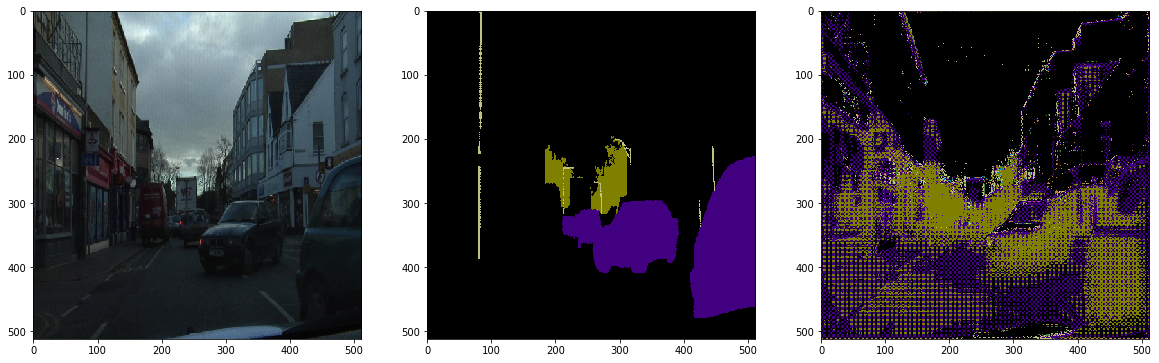

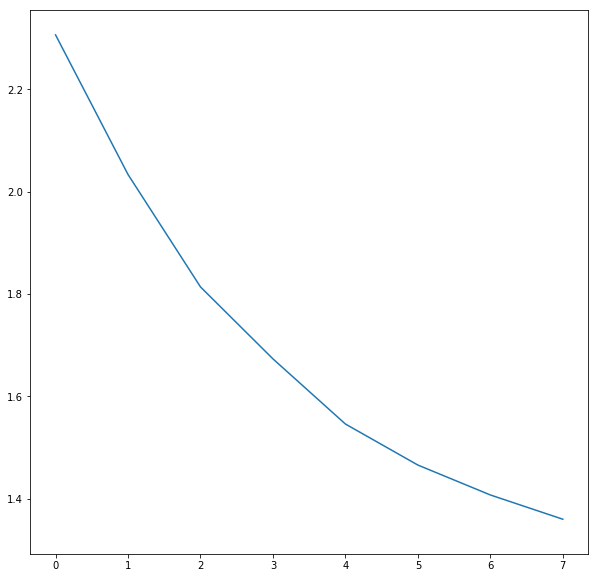

Epoch : 1
Training .....
Epoch 1/1
80/80 [==============================] - 10s 127ms/step - loss: 1.2893 - jaccard_distance: 1.3201
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 1.2505 - jaccard_distance: 1.2992
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 1.2188 - jaccard_distance: 1.2847
Epoch 1/1
80/80 [==============================] - 10s 130ms/step - loss: 1.1967 - jaccard_distance: 1.2568
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 1.1476 - jaccard_distance: 1.2409
Epoch 1/1
80/80 [==============================] - 10s 130ms/step - loss: 1.1227 - jaccard_distance: 1.2231
Epoch 1/1
80/80 [==============================] - 10s 130ms/step - loss: 1.0985 - jaccard_distance: 1.2040
Epoch 1/1
69/69 [==============================] - 9s 129ms/step - loss: 1.1297 - jaccard_distance: 1.1984
Validating .....
Epoch 1/1
16/16 [==============================] - 2s 132ms/step - loss: 1.1519 - jaccard_dista

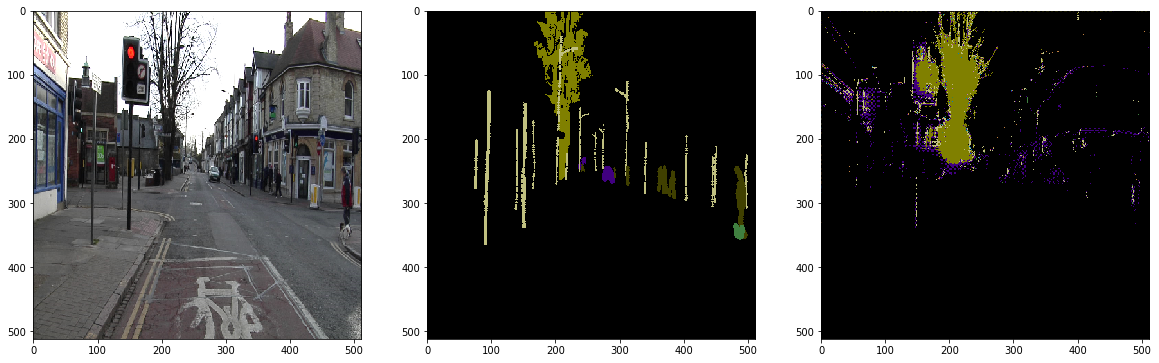

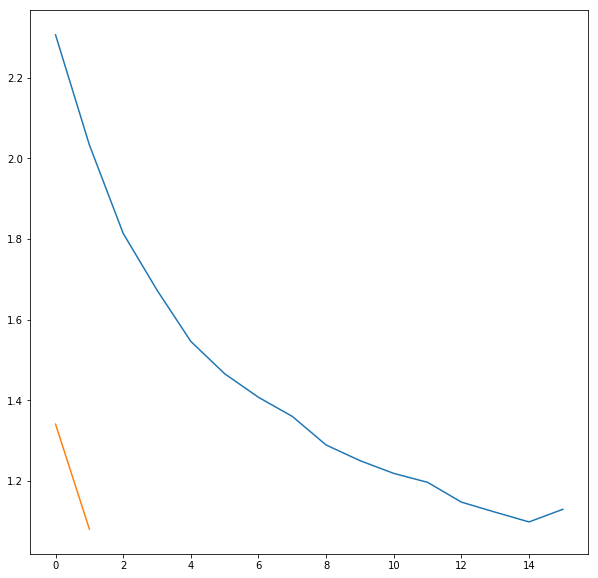

Epoch : 2
Training .....
Epoch 1/1
80/80 [==============================] - 10s 128ms/step - loss: 1.0314 - jaccard_distance: 1.1581
Epoch 1/1
80/80 [==============================] - 10s 128ms/step - loss: 1.0018 - jaccard_distance: 1.1333
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 1.0109 - jaccard_distance: 1.1292
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 1.0219 - jaccard_distance: 1.1341
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.9791 - jaccard_distance: 1.1115
Epoch 1/1
80/80 [==============================] - 10s 130ms/step - loss: 0.9752 - jaccard_distance: 1.1016
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.9485 - jaccard_distance: 1.0787
Epoch 1/1
69/69 [==============================] - 9s 129ms/step - loss: 0.9361 - jaccard_distance: 1.0659
Validating .....
Epoch 1/1
16/16 [==============================] - 2s 131ms/step - loss: 0.9413 - jaccard_dista

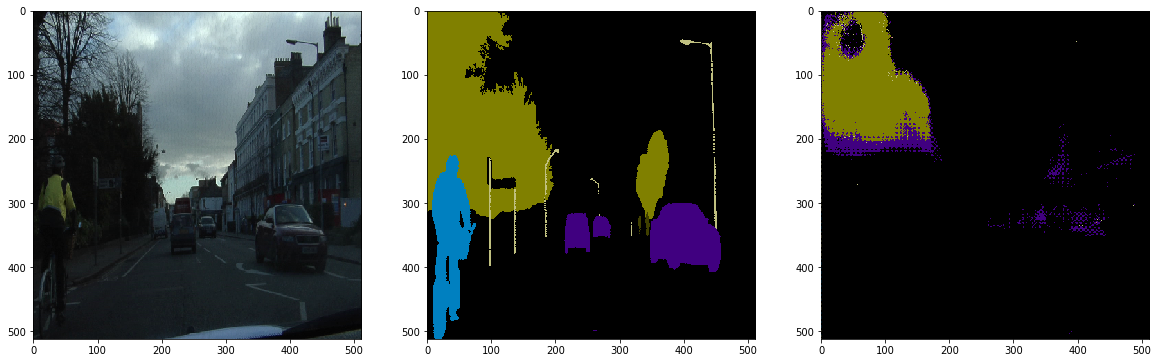

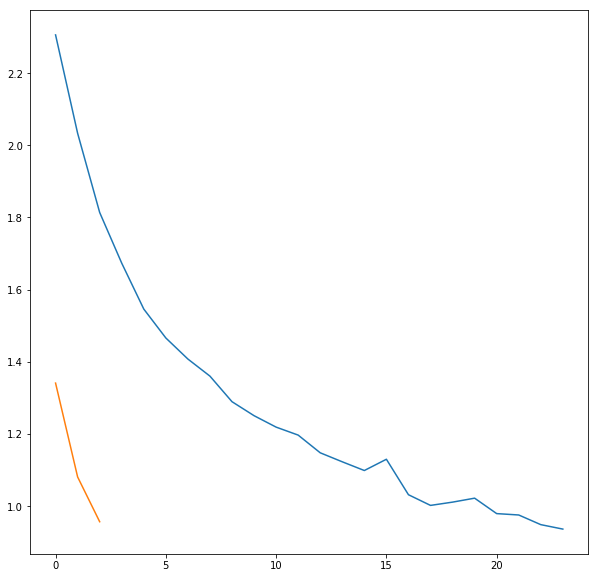

Epoch : 3
Training .....
Epoch 1/1
80/80 [==============================] - 10s 127ms/step - loss: 0.8920 - jaccard_distance: 1.0404
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.9128 - jaccard_distance: 1.0379
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.8543 - jaccard_distance: 1.0146
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.8759 - jaccard_distance: 1.0104
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.8412 - jaccard_distance: 0.9940
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.8321 - jaccard_distance: 0.9879
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.7952 - jaccard_distance: 0.9597
Epoch 1/1
69/69 [==============================] - 9s 129ms/step - loss: 0.8198 - jaccard_distance: 0.9679
Validating .....
Epoch 1/1
16/16 [==============================] - 2s 130ms/step - loss: 0.7897 - jaccard_dista

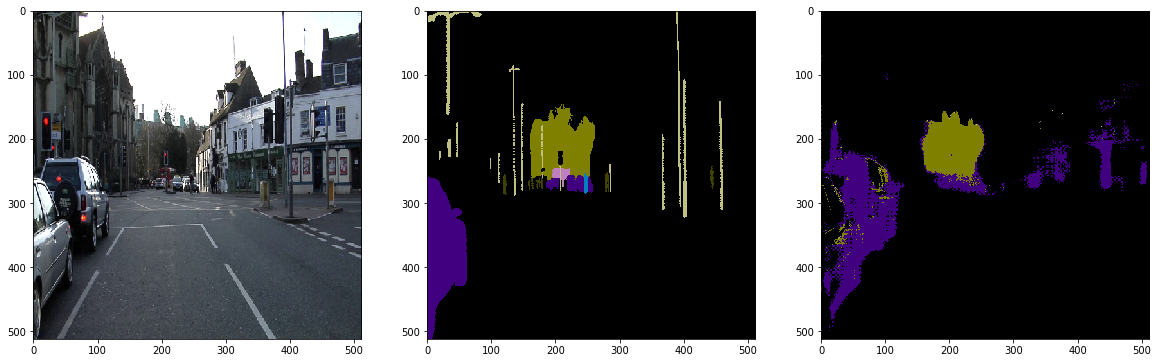

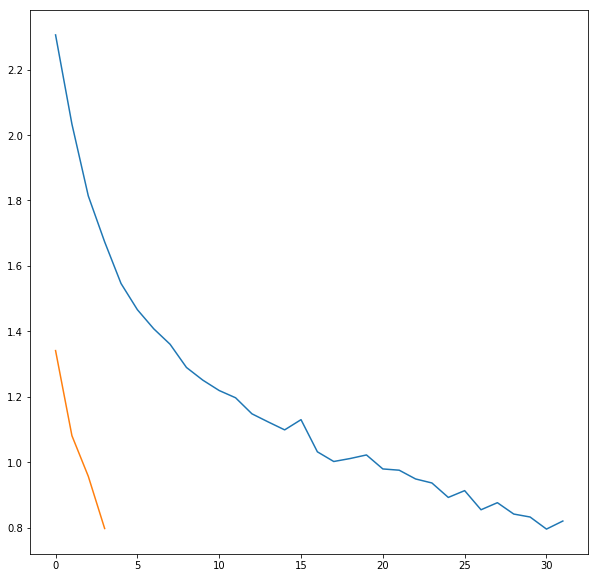

Epoch : 4
Training .....
Epoch 1/1
80/80 [==============================] - 10s 128ms/step - loss: 0.7974 - jaccard_distance: 0.9495
Epoch 1/1
80/80 [==============================] - 10s 128ms/step - loss: 0.7585 - jaccard_distance: 0.9265
Epoch 1/1
80/80 [==============================] - 10s 130ms/step - loss: 0.7442 - jaccard_distance: 0.9076
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.7487 - jaccard_distance: 0.9008
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.7522 - jaccard_distance: 0.9042
Epoch 1/1
80/80 [==============================] - 10s 130ms/step - loss: 0.7256 - jaccard_distance: 0.8716
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.7308 - jaccard_distance: 0.8785
Epoch 1/1
69/69 [==============================] - 9s 128ms/step - loss: 0.7201 - jaccard_distance: 0.8713
Validating .....
Epoch 1/1
16/16 [==============================] - 2s 131ms/step - loss: 0.7255 - jaccard_dista

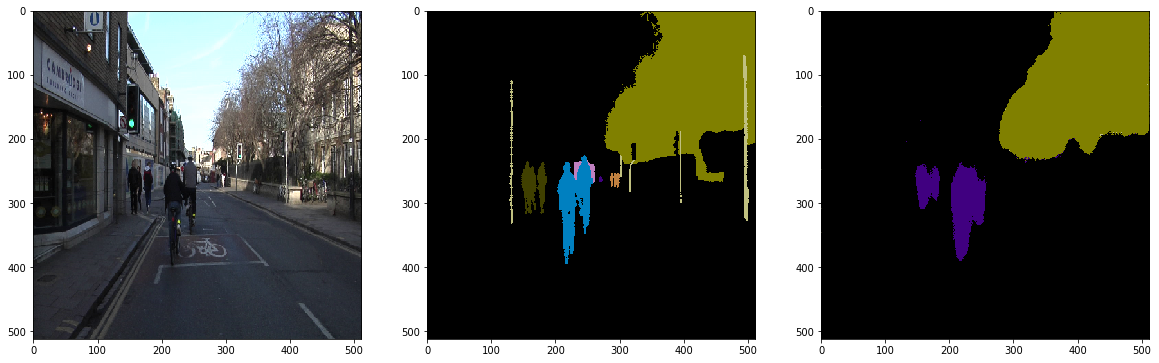

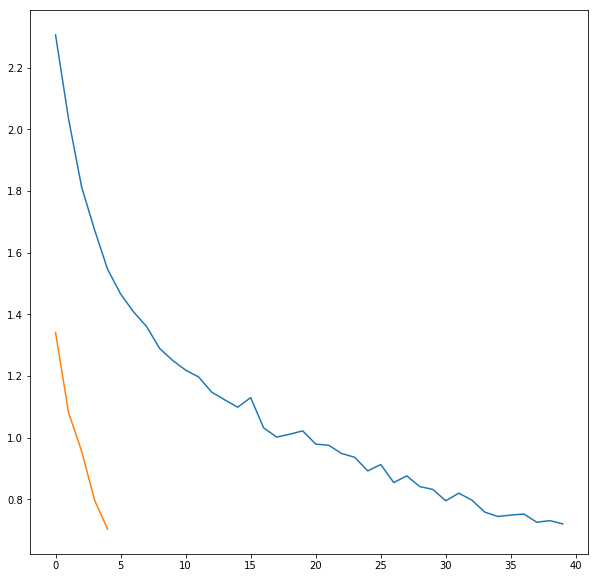

Epoch : 5
Training .....
Epoch 1/1
80/80 [==============================] - 10s 128ms/step - loss: 0.6947 - jaccard_distance: 0.8394
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.7181 - jaccard_distance: 0.8442
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.6713 - jaccard_distance: 0.8330
Epoch 1/1
80/80 [==============================] - 10s 130ms/step - loss: 0.6682 - jaccard_distance: 0.8250
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.6189 - jaccard_distance: 0.7895
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.6322 - jaccard_distance: 0.7917
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.6275 - jaccard_distance: 0.7838
Epoch 1/1
69/69 [==============================] - 9s 129ms/step - loss: 0.6562 - jaccard_distance: 0.7770
Validating .....
Epoch 1/1
16/16 [==============================] - 2s 131ms/step - loss: 0.6117 - jaccard_dista

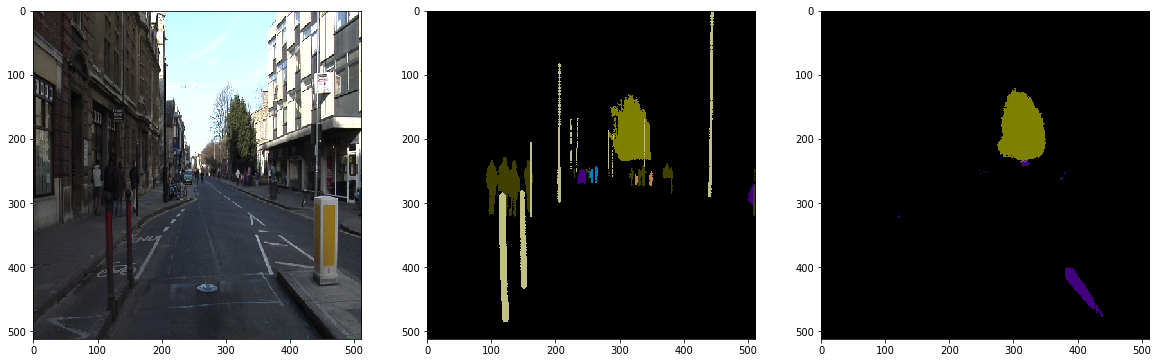

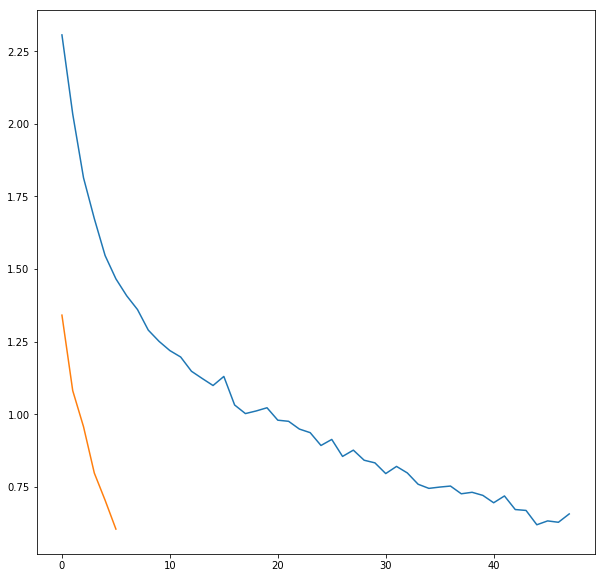

Epoch : 6
Training .....
Epoch 1/1
80/80 [==============================] - 10s 128ms/step - loss: 0.5790 - jaccard_distance: 0.7423
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.5807 - jaccard_distance: 0.7214
Epoch 1/1
80/80 [==============================] - 10s 130ms/step - loss: 0.6061 - jaccard_distance: 0.7392
Epoch 1/1
80/80 [==============================] - 10s 130ms/step - loss: 0.5978 - jaccard_distance: 0.7287
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.5662 - jaccard_distance: 0.7143
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.5662 - jaccard_distance: 0.7235
Epoch 1/1
80/80 [==============================] - 10s 130ms/step - loss: 0.5554 - jaccard_distance: 0.7057
Epoch 1/1
69/69 [==============================] - 9s 129ms/step - loss: 0.5712 - jaccard_distance: 0.7007
Validating .....
Epoch 1/1
16/16 [==============================] - 2s 129ms/step - loss: 0.5652 - jaccard_dista

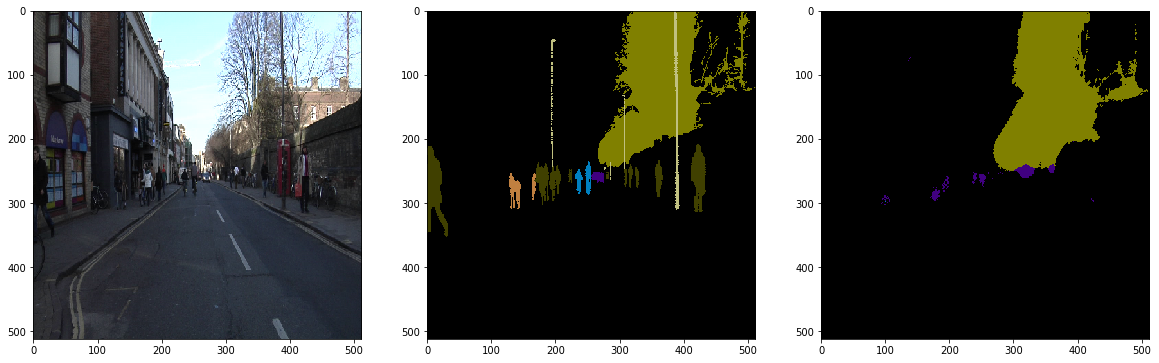

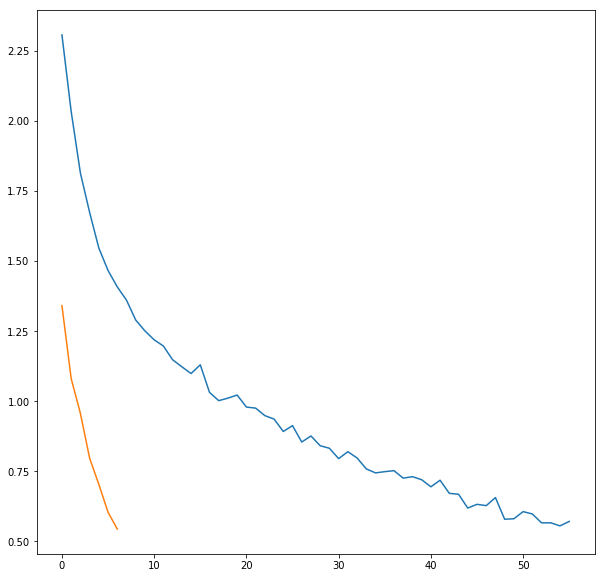

Epoch : 7
Training .....
Epoch 1/1
80/80 [==============================] - 10s 128ms/step - loss: 0.5210 - jaccard_distance: 0.6740
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.5415 - jaccard_distance: 0.6703
Epoch 1/1
80/80 [==============================] - 10s 130ms/step - loss: 0.5294 - jaccard_distance: 0.6555
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.5420 - jaccard_distance: 0.6614
Epoch 1/1
80/80 [==============================] - 10s 128ms/step - loss: 0.5891 - jaccard_distance: 0.6906
Epoch 1/1
80/80 [==============================] - 10s 130ms/step - loss: 0.5666 - jaccard_distance: 0.6817
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.5246 - jaccard_distance: 0.6500
Epoch 1/1
69/69 [==============================] - 9s 129ms/step - loss: 0.5428 - jaccard_distance: 0.6476
Validating .....
Epoch 1/1
16/16 [==============================] - 2s 130ms/step - loss: 0.5142 - jaccard_dista

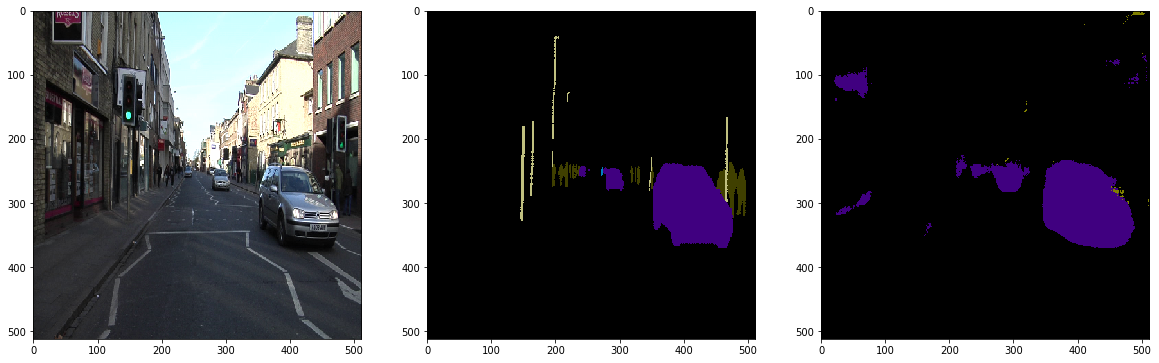

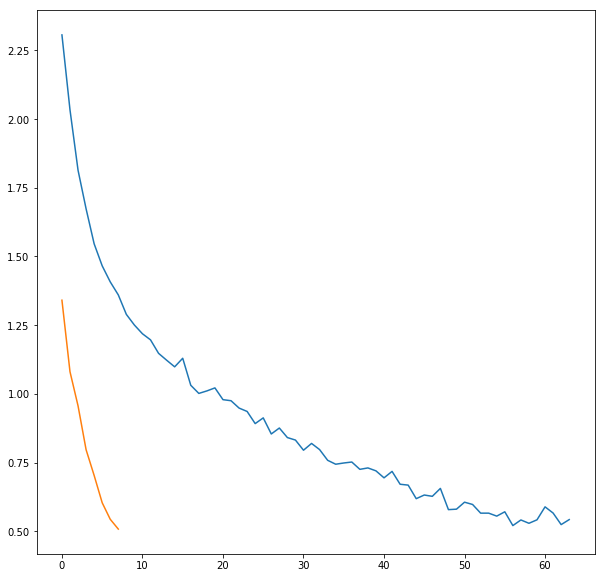

Epoch : 8
Training .....
Epoch 1/1
80/80 [==============================] - 10s 128ms/step - loss: 0.5258 - jaccard_distance: 0.6273
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.4673 - jaccard_distance: 0.6078
Epoch 1/1
80/80 [==============================] - 10s 130ms/step - loss: 0.5042 - jaccard_distance: 0.6120
Epoch 1/1
80/80 [==============================] - 10s 130ms/step - loss: 0.4663 - jaccard_distance: 0.5884
Epoch 1/1
80/80 [==============================] - 10s 130ms/step - loss: 0.4733 - jaccard_distance: 0.5829
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.4599 - jaccard_distance: 0.5804
Epoch 1/1
80/80 [==============================] - 10s 128ms/step - loss: 0.4613 - jaccard_distance: 0.5790
Epoch 1/1
69/69 [==============================] - 9s 129ms/step - loss: 0.4602 - jaccard_distance: 0.5710
Validating .....
Epoch 1/1
16/16 [==============================] - 2s 131ms/step - loss: 0.3921 - jaccard_dista

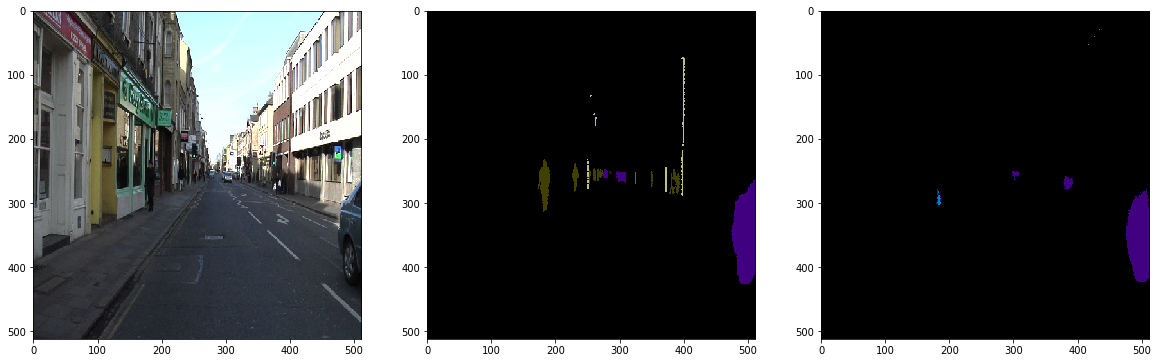

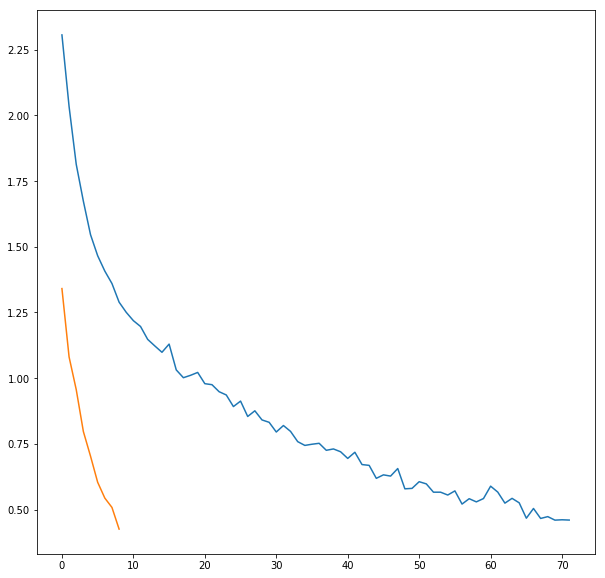

Epoch : 9
Training .....
Epoch 1/1
80/80 [==============================] - 10s 128ms/step - loss: 0.4548 - jaccard_distance: 0.5595
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.4318 - jaccard_distance: 0.5463
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.4258 - jaccard_distance: 0.5431
Epoch 1/1
80/80 [==============================] - 10s 130ms/step - loss: 0.4169 - jaccard_distance: 0.5277
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.4298 - jaccard_distance: 0.5389
Epoch 1/1
80/80 [==============================] - 10s 130ms/step - loss: 0.4057 - jaccard_distance: 0.5188
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.4261 - jaccard_distance: 0.5180
Epoch 1/1
69/69 [==============================] - 9s 129ms/step - loss: 0.4085 - jaccard_distance: 0.5049
Validating .....
Epoch 1/1
16/16 [==============================] - 2s 133ms/step - loss: 0.3828 - jaccard_dista

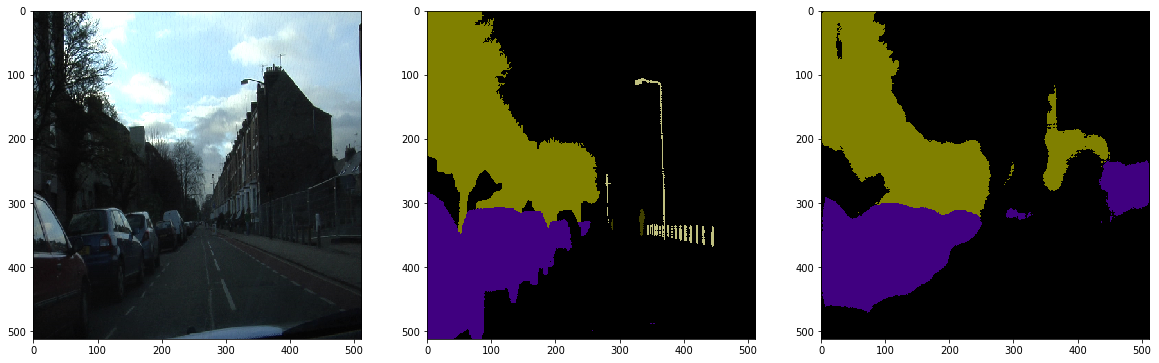

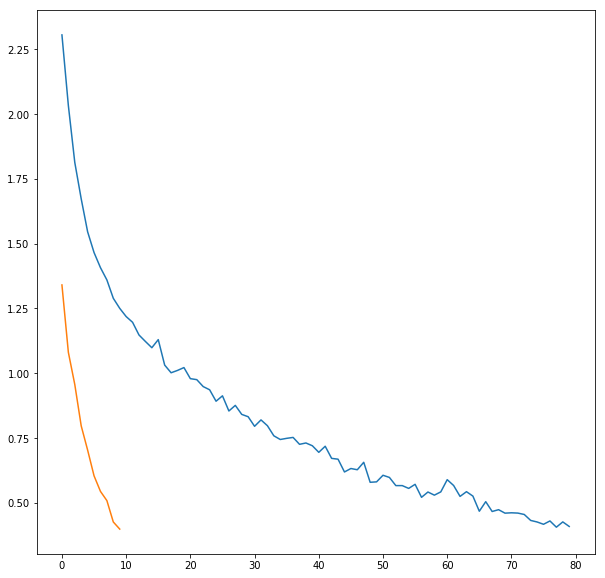

Epoch : 10
Training .....
Epoch 1/1
80/80 [==============================] - 10s 128ms/step - loss: 0.4002 - jaccard_distance: 0.4972
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.3900 - jaccard_distance: 0.4860
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.3952 - jaccard_distance: 0.4905
Epoch 1/1
80/80 [==============================] - 10s 130ms/step - loss: 0.3928 - jaccard_distance: 0.4788
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.3587 - jaccard_distance: 0.4670
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.4443 - jaccard_distance: 0.5088
Epoch 1/1
80/80 [==============================] - 10s 130ms/step - loss: 0.3892 - jaccard_distance: 0.4869
Epoch 1/1
69/69 [==============================] - 9s 129ms/step - loss: 0.3868 - jaccard_distance: 0.4759
Validating .....
Epoch 1/1
16/16 [==============================] - 2s 132ms/step - loss: 0.4250 - jaccard_dist

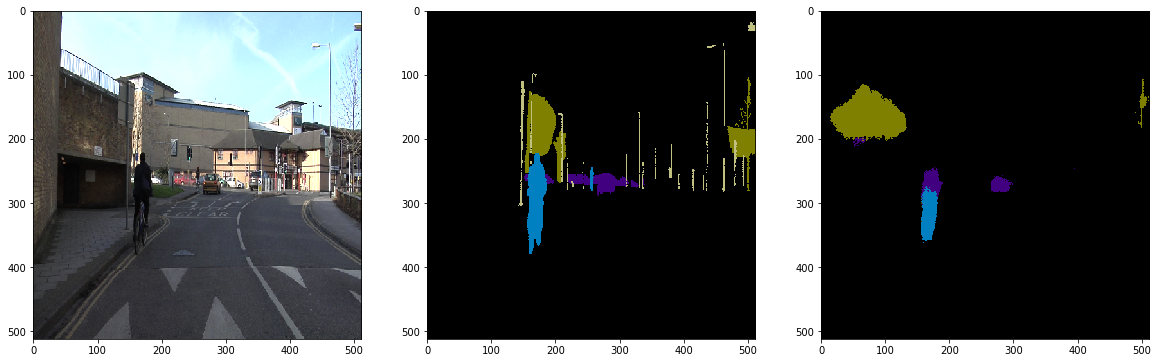

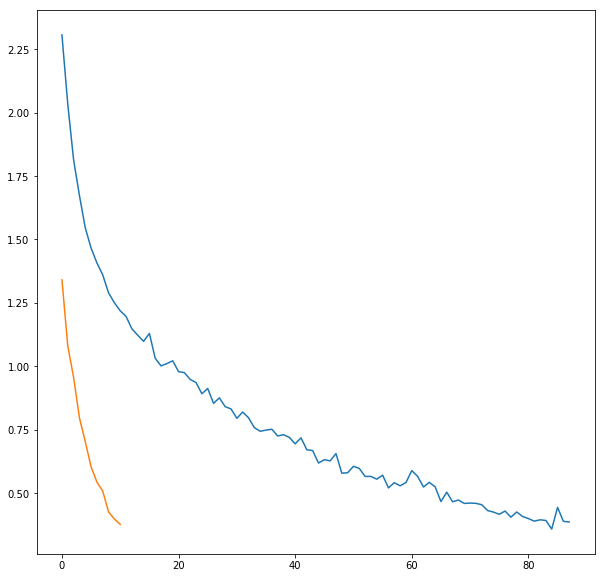

Epoch : 11
Training .....
Epoch 1/1
80/80 [==============================] - 10s 127ms/step - loss: 0.3725 - jaccard_distance: 0.4538
Epoch 1/1
80/80 [==============================] - 10s 128ms/step - loss: 0.4004 - jaccard_distance: 0.4681
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.3686 - jaccard_distance: 0.4545
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.3611 - jaccard_distance: 0.4479
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.3843 - jaccard_distance: 0.4559
Epoch 1/1
80/80 [==============================] - 10s 130ms/step - loss: 0.3516 - jaccard_distance: 0.4438
Epoch 1/1
80/80 [==============================] - 10s 130ms/step - loss: 0.3291 - jaccard_distance: 0.4236
Epoch 1/1
69/69 [==============================] - 9s 129ms/step - loss: 0.3539 - jaccard_distance: 0.4284
Validating .....
Epoch 1/1
16/16 [==============================] - 2s 133ms/step - loss: 0.3226 - jaccard_dist

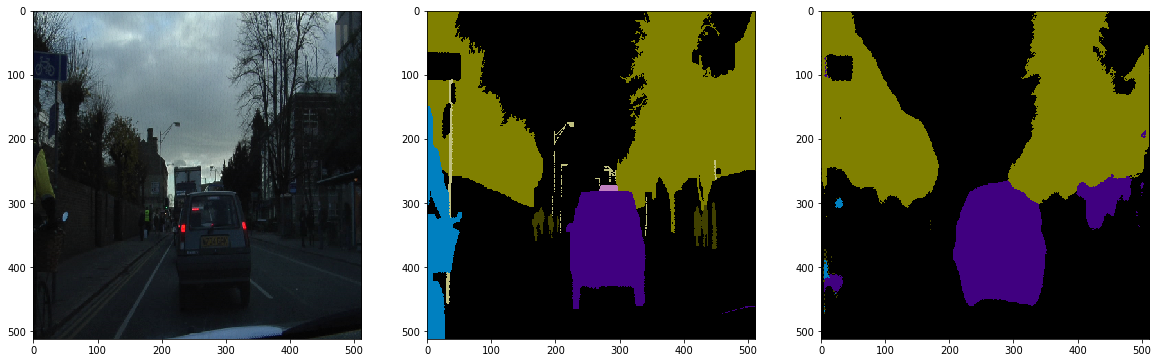

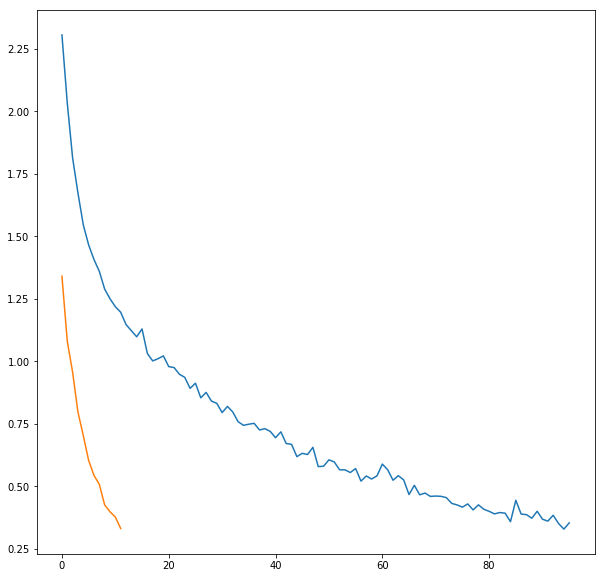

Epoch : 12
Training .....
Epoch 1/1
80/80 [==============================] - 10s 128ms/step - loss: 0.3158 - jaccard_distance: 0.4031
Epoch 1/1
80/80 [==============================] - 10s 128ms/step - loss: 0.3425 - jaccard_distance: 0.4140
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.3332 - jaccard_distance: 0.4115
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.2971 - jaccard_distance: 0.3847
Epoch 1/1
80/80 [==============================] - 10s 130ms/step - loss: 0.3425 - jaccard_distance: 0.3944
Epoch 1/1
80/80 [==============================] - 10s 130ms/step - loss: 0.3218 - jaccard_distance: 0.3941
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.3331 - jaccard_distance: 0.3972
Epoch 1/1
69/69 [==============================] - 9s 128ms/step - loss: 0.3100 - jaccard_distance: 0.3861
Validating .....
Epoch 1/1
16/16 [==============================] - 2s 130ms/step - loss: 0.3116 - jaccard_dist

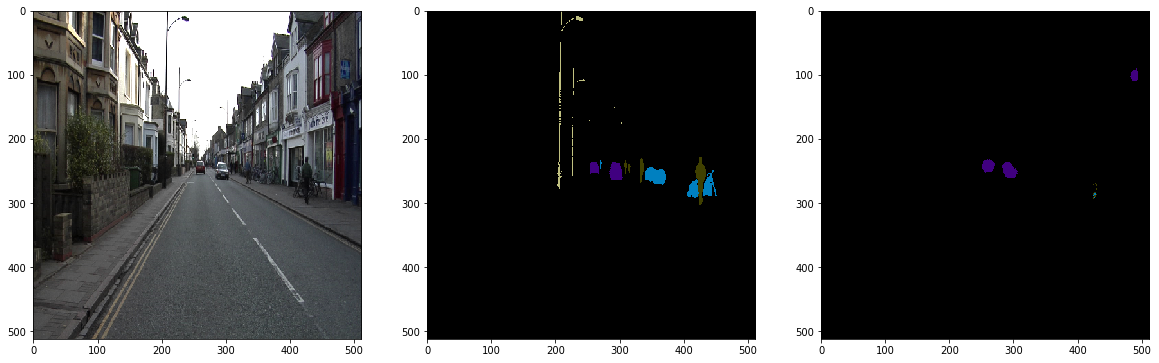

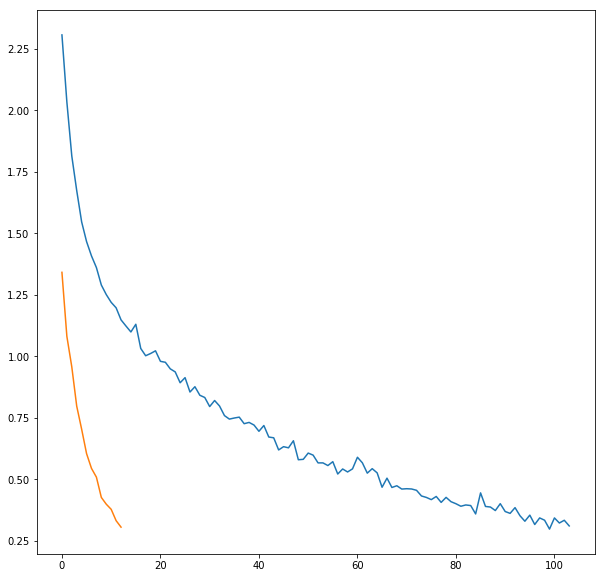

Epoch : 13
Training .....
Epoch 1/1
80/80 [==============================] - 10s 127ms/step - loss: 0.3146 - jaccard_distance: 0.3814
Epoch 1/1
80/80 [==============================] - 10s 128ms/step - loss: 0.3078 - jaccard_distance: 0.3818
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.3085 - jaccard_distance: 0.3638
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.3171 - jaccard_distance: 0.3754
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.2991 - jaccard_distance: 0.3655
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.2898 - jaccard_distance: 0.3572
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.3101 - jaccard_distance: 0.3746
Epoch 1/1
69/69 [==============================] - 9s 129ms/step - loss: 0.3005 - jaccard_distance: 0.3624
Validating .....
Epoch 1/1
16/16 [==============================] - 2s 131ms/step - loss: 0.3283 - jaccard_dist

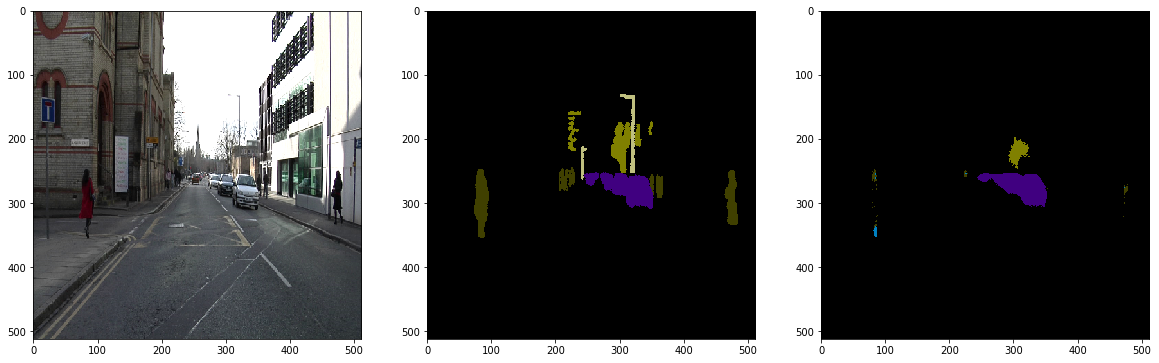

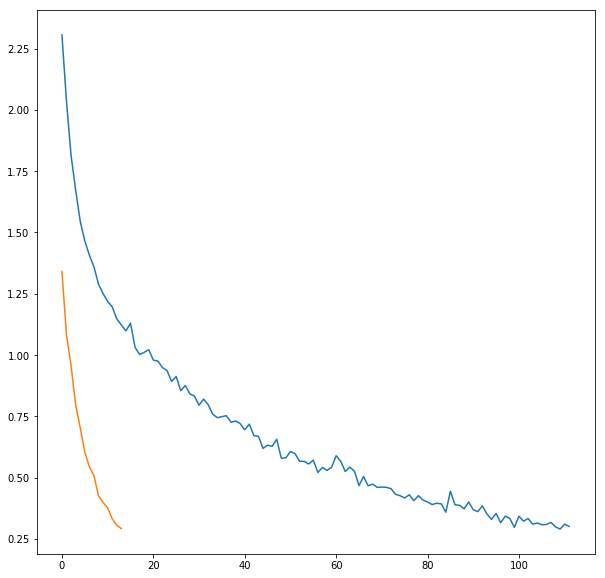

Epoch : 14
Training .....
Epoch 1/1
80/80 [==============================] - 10s 128ms/step - loss: 0.2846 - jaccard_distance: 0.3474
Epoch 1/1
80/80 [==============================] - 10s 128ms/step - loss: 0.2843 - jaccard_distance: 0.3481
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.2858 - jaccard_distance: 0.3468
Epoch 1/1
80/80 [==============================] - 10s 130ms/step - loss: 0.2856 - jaccard_distance: 0.3416
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.2838 - jaccard_distance: 0.3393
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.2733 - jaccard_distance: 0.3321
Epoch 1/1
80/80 [==============================] - 10s 130ms/step - loss: 0.2707 - jaccard_distance: 0.3362
Epoch 1/1
69/69 [==============================] - 9s 129ms/step - loss: 0.3135 - jaccard_distance: 0.3523
Validating .....
Epoch 1/1
16/16 [==============================] - 2s 132ms/step - loss: 0.2867 - jaccard_dist

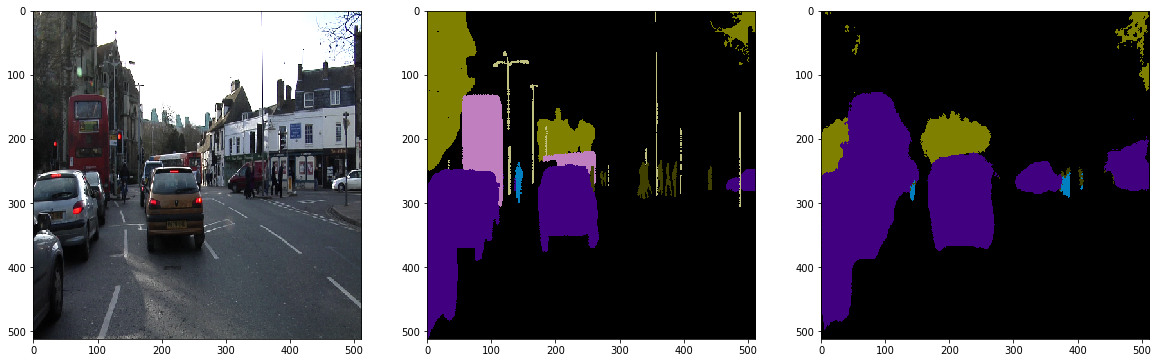

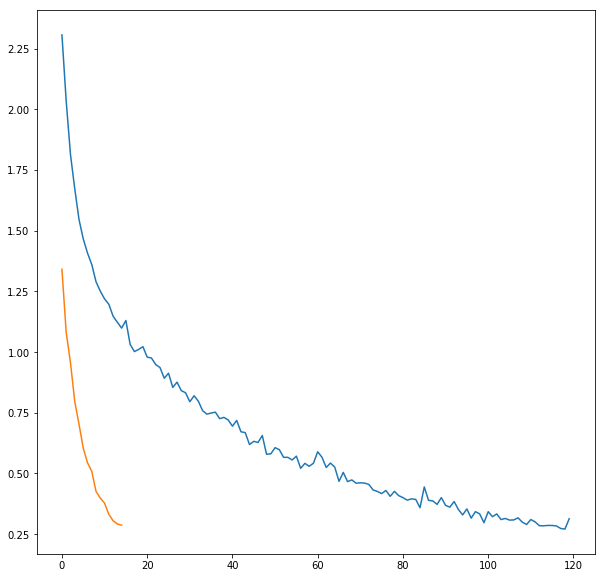

Epoch : 15
Training .....
Epoch 1/1
80/80 [==============================] - 10s 127ms/step - loss: 0.2733 - jaccard_distance: 0.3284
Epoch 1/1
80/80 [==============================] - 10s 128ms/step - loss: 0.2573 - jaccard_distance: 0.3158
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.2805 - jaccard_distance: 0.3317
Epoch 1/1
80/80 [==============================] - 10s 130ms/step - loss: 0.2962 - jaccard_distance: 0.3347
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.2640 - jaccard_distance: 0.3210
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.2739 - jaccard_distance: 0.3181
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.2733 - jaccard_distance: 0.3234
Epoch 1/1
69/69 [==============================] - 9s 129ms/step - loss: 0.2665 - jaccard_distance: 0.3184
Validating .....
Epoch 1/1
16/16 [==============================] - 2s 130ms/step - loss: 0.2812 - jaccard_dist

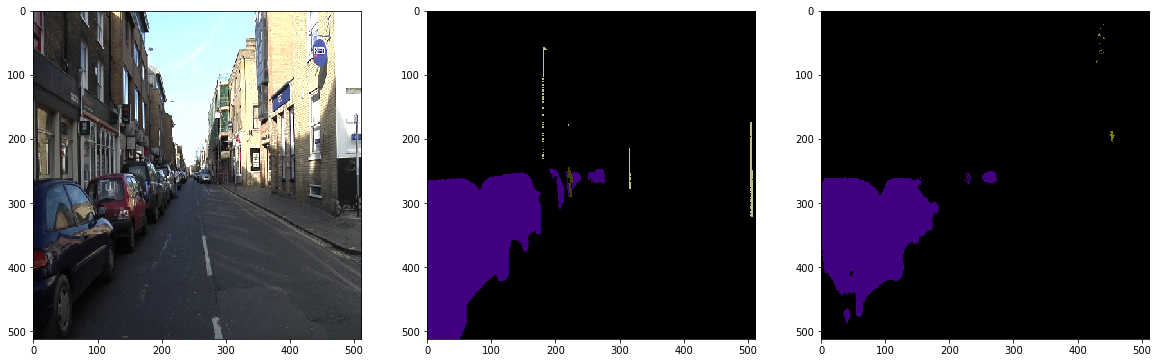

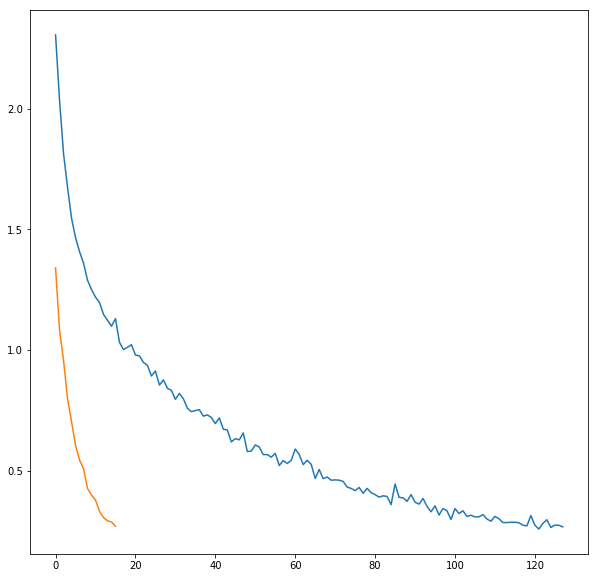

Epoch : 16
Training .....
Epoch 1/1
80/80 [==============================] - 10s 128ms/step - loss: 0.2577 - jaccard_distance: 0.3124
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.2491 - jaccard_distance: 0.3040
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.2529 - jaccard_distance: 0.3010
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.2579 - jaccard_distance: 0.2968
Epoch 1/1
80/80 [==============================] - 10s 128ms/step - loss: 0.2695 - jaccard_distance: 0.3142
Epoch 1/1
80/80 [==============================] - 10s 128ms/step - loss: 0.2544 - jaccard_distance: 0.3004
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.2437 - jaccard_distance: 0.2925
Epoch 1/1
69/69 [==============================] - 9s 129ms/step - loss: 0.2744 - jaccard_distance: 0.3073
Validating .....
Epoch 1/1
16/16 [==============================] - 2s 132ms/step - loss: 0.2370 - jaccard_dist

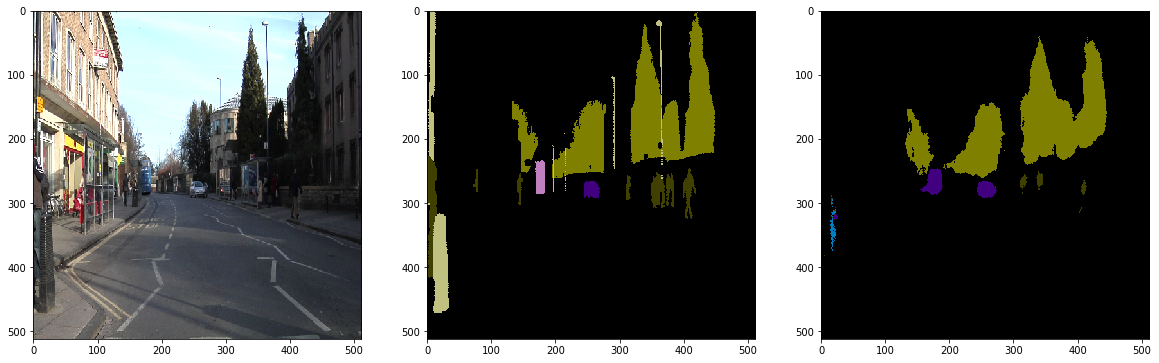

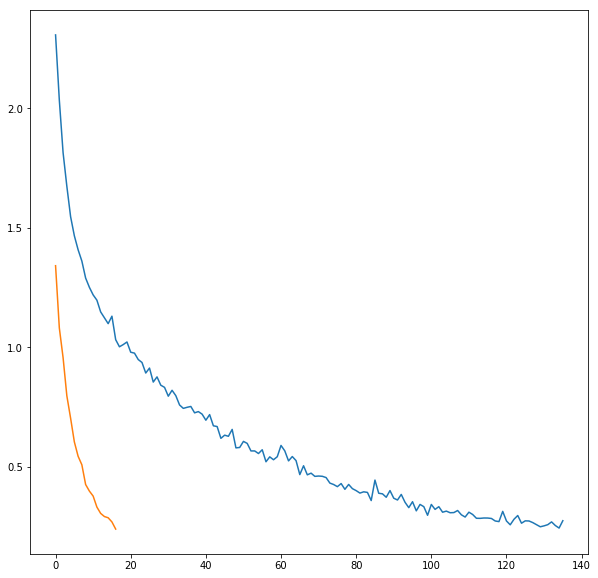

Epoch : 17
Training .....
Epoch 1/1
80/80 [==============================] - 10s 127ms/step - loss: 0.2357 - jaccard_distance: 0.2816
Epoch 1/1
80/80 [==============================] - 10s 128ms/step - loss: 0.2320 - jaccard_distance: 0.2740
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.2515 - jaccard_distance: 0.2872
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.2498 - jaccard_distance: 0.2911
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.2381 - jaccard_distance: 0.2873
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.2379 - jaccard_distance: 0.2825
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.2499 - jaccard_distance: 0.2897
Epoch 1/1
69/69 [==============================] - 9s 129ms/step - loss: 0.2361 - jaccard_distance: 0.2785
Validating .....
Epoch 1/1
16/16 [==============================] - 2s 131ms/step - loss: 0.2458 - jaccard_dist

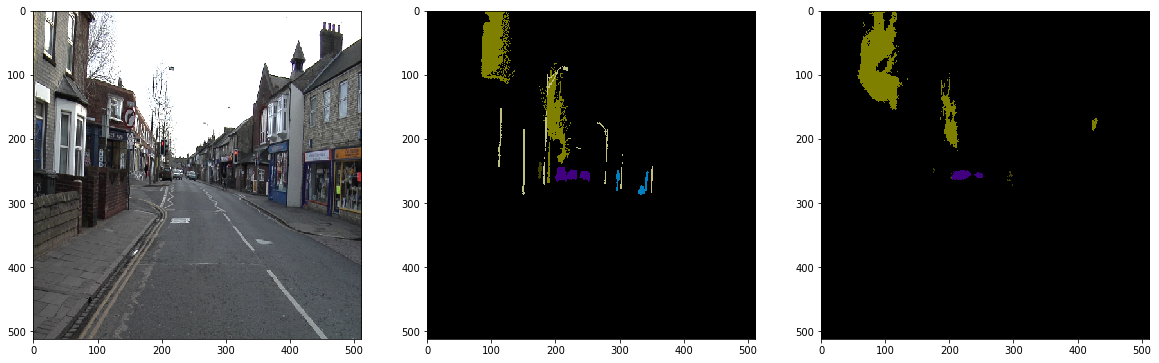

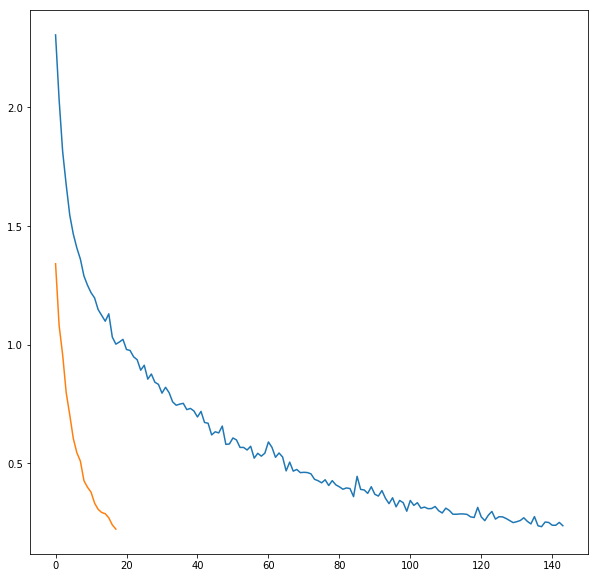

Epoch : 18
Training .....
Epoch 1/1
80/80 [==============================] - 10s 127ms/step - loss: 0.2177 - jaccard_distance: 0.2616
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.2345 - jaccard_distance: 0.2705
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.2532 - jaccard_distance: 0.2815
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.2263 - jaccard_distance: 0.2676
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.2338 - jaccard_distance: 0.2731
Epoch 1/1
80/80 [==============================] - 10s 130ms/step - loss: 0.2092 - jaccard_distance: 0.2541
Epoch 1/1
80/80 [==============================] - 10s 128ms/step - loss: 0.2247 - jaccard_distance: 0.2583
Epoch 1/1
69/69 [==============================] - 9s 129ms/step - loss: 0.2138 - jaccard_distance: 0.2547
Validating .....
Epoch 1/1
16/16 [==============================] - 2s 130ms/step - loss: 0.2158 - jaccard_dist

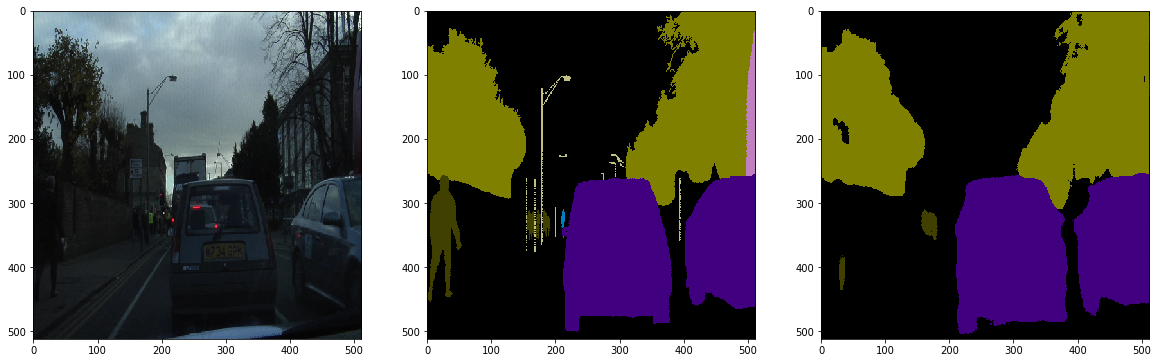

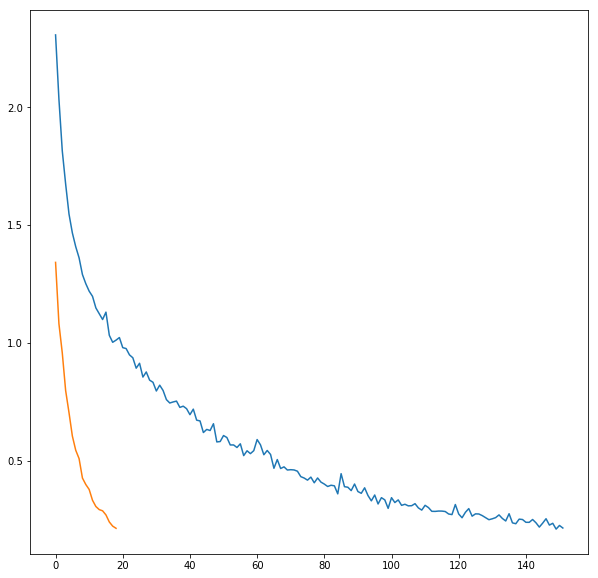

Epoch : 19
Training .....
Epoch 1/1
80/80 [==============================] - 10s 128ms/step - loss: 0.2298 - jaccard_distance: 0.2607
Epoch 1/1
80/80 [==============================] - 10s 128ms/step - loss: 0.2052 - jaccard_distance: 0.2468
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.2143 - jaccard_distance: 0.2506
Epoch 1/1
80/80 [==============================] - 10s 130ms/step - loss: 0.2025 - jaccard_distance: 0.2435
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.2076 - jaccard_distance: 0.2468
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.2120 - jaccard_distance: 0.2451
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.2208 - jaccard_distance: 0.2581
Epoch 1/1
69/69 [==============================] - 9s 129ms/step - loss: 0.2141 - jaccard_distance: 0.2464
Validating .....
Epoch 1/1
16/16 [==============================] - 2s 131ms/step - loss: 0.1983 - jaccard_dist

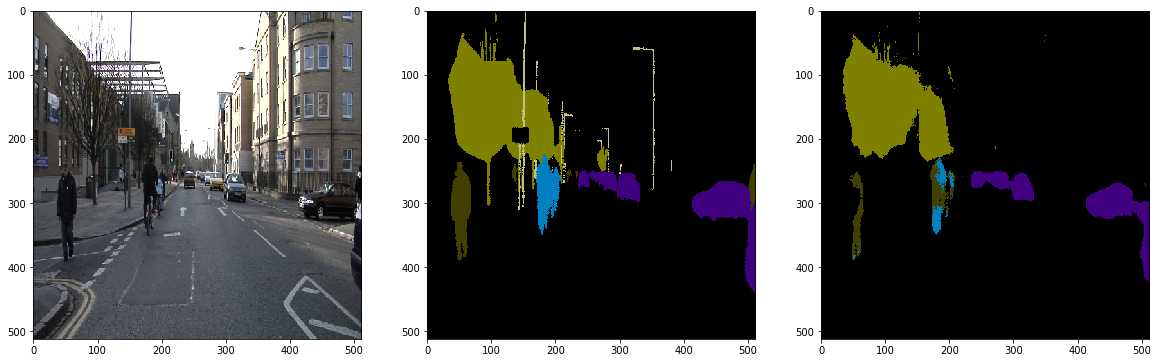

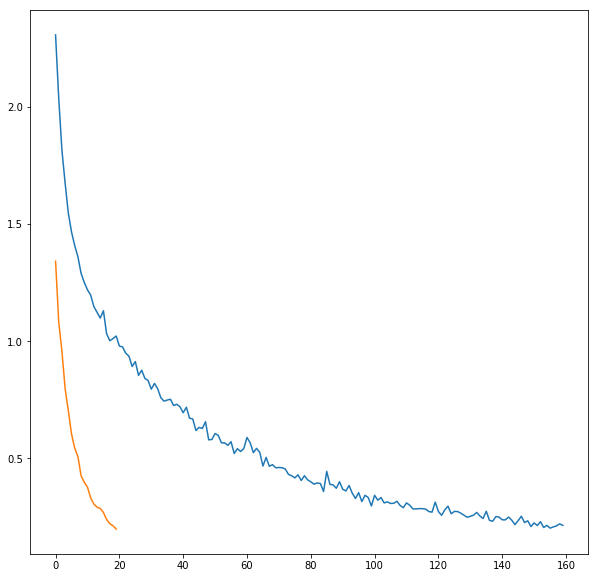

Epoch : 20
Training .....
Epoch 1/1
80/80 [==============================] - 10s 128ms/step - loss: 0.2071 - jaccard_distance: 0.2397
Epoch 1/1
80/80 [==============================] - 10s 128ms/step - loss: 0.2066 - jaccard_distance: 0.2460
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.2183 - jaccard_distance: 0.2480
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.1894 - jaccard_distance: 0.2314
Epoch 1/1
80/80 [==============================] - 10s 128ms/step - loss: 0.2011 - jaccard_distance: 0.2346
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.1895 - jaccard_distance: 0.2233
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.2058 - jaccard_distance: 0.2392
Epoch 1/1
69/69 [==============================] - 9s 130ms/step - loss: 0.1933 - jaccard_distance: 0.2286
Validating .....
Epoch 1/1
16/16 [==============================] - 2s 132ms/step - loss: 0.2205 - jaccard_dist

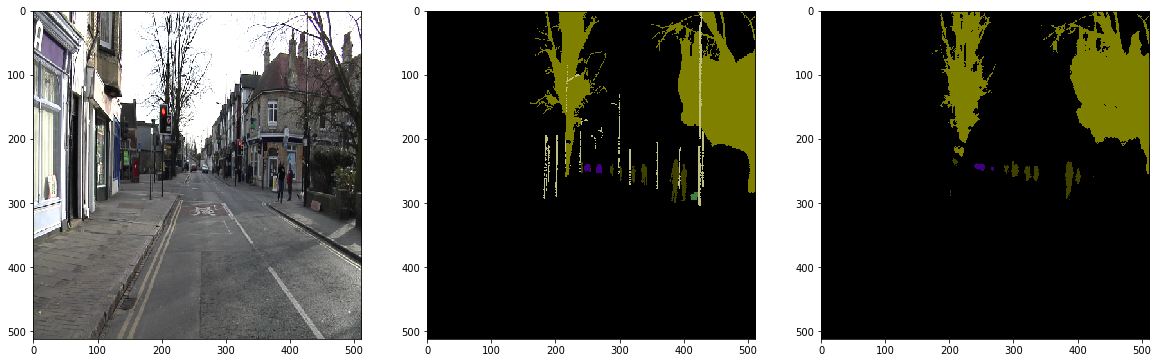

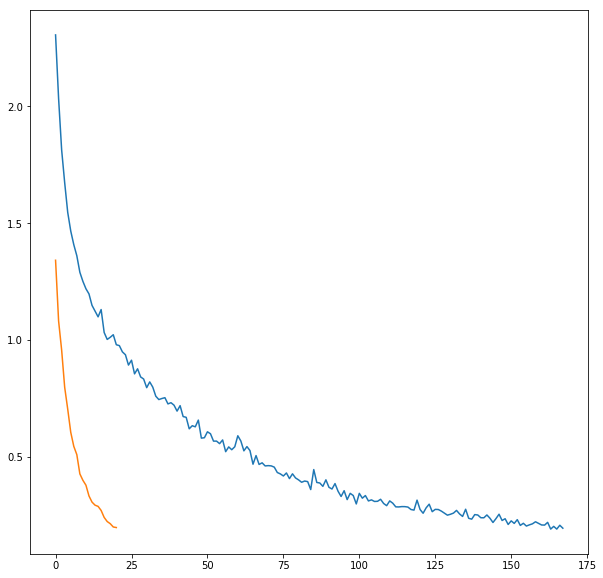

Epoch : 21
Training .....
Epoch 1/1
80/80 [==============================] - 10s 128ms/step - loss: 0.1784 - jaccard_distance: 0.2151
Epoch 1/1
80/80 [==============================] - 10s 128ms/step - loss: 0.2029 - jaccard_distance: 0.2322
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.1917 - jaccard_distance: 0.2244
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.1771 - jaccard_distance: 0.2126
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.1778 - jaccard_distance: 0.2138
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.1877 - jaccard_distance: 0.2165
Epoch 1/1
80/80 [==============================] - 10s 130ms/step - loss: 0.1990 - jaccard_distance: 0.2337
Epoch 1/1
69/69 [==============================] - 9s 130ms/step - loss: 0.1864 - jaccard_distance: 0.2196
Validating .....
Epoch 1/1
16/16 [==============================] - 2s 130ms/step - loss: 0.1731 - jaccard_dist

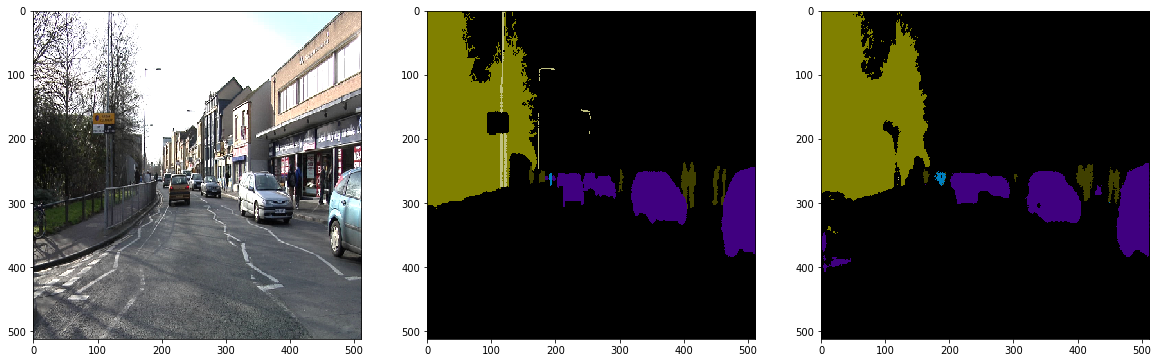

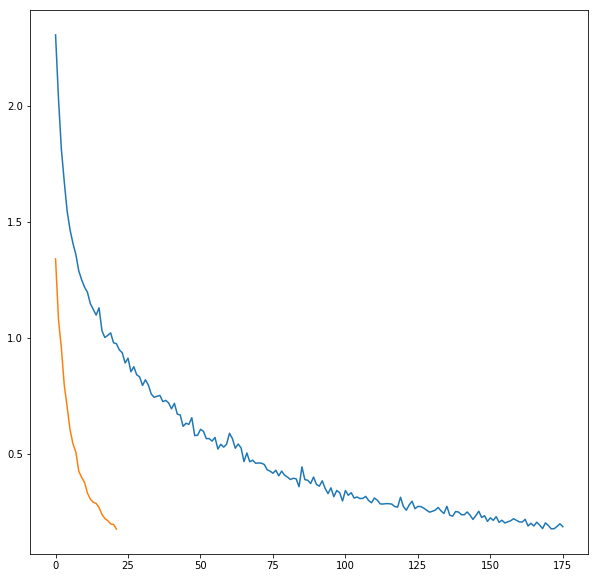

Epoch : 22
Training .....
Epoch 1/1
80/80 [==============================] - 10s 128ms/step - loss: 0.1834 - jaccard_distance: 0.2206
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.1817 - jaccard_distance: 0.2142
Epoch 1/1
80/80 [==============================] - 10s 130ms/step - loss: 0.1738 - jaccard_distance: 0.2096
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.1809 - jaccard_distance: 0.2137
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.1804 - jaccard_distance: 0.2113
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.1919 - jaccard_distance: 0.2223
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.1824 - jaccard_distance: 0.2139
Epoch 1/1
69/69 [==============================] - 9s 129ms/step - loss: 0.1766 - jaccard_distance: 0.2063
Validating .....
Epoch 1/1
16/16 [==============================] - 2s 131ms/step - loss: 0.1809 - jaccard_dist

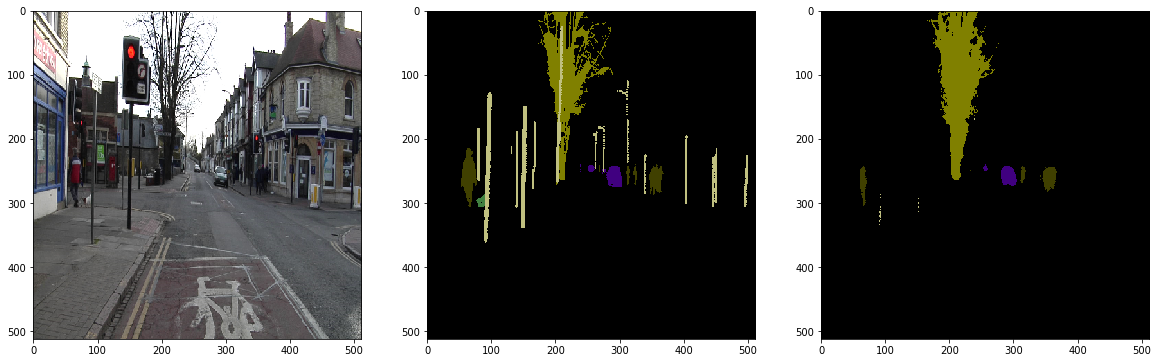

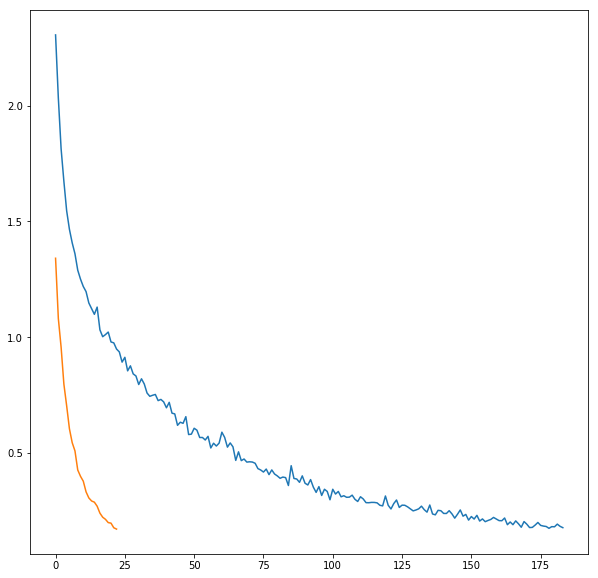

Epoch : 23
Training .....
Epoch 1/1
80/80 [==============================] - 10s 127ms/step - loss: 0.1625 - jaccard_distance: 0.1939
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.1663 - jaccard_distance: 0.1962
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.1672 - jaccard_distance: 0.1989
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.1643 - jaccard_distance: 0.2000
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.1620 - jaccard_distance: 0.1945
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.1712 - jaccard_distance: 0.2000
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.1655 - jaccard_distance: 0.1965
Epoch 1/1
69/69 [==============================] - 9s 129ms/step - loss: 0.1786 - jaccard_distance: 0.2017
Validating .....
Epoch 1/1
16/16 [==============================] - 2s 131ms/step - loss: 0.1653 - jaccard_dist

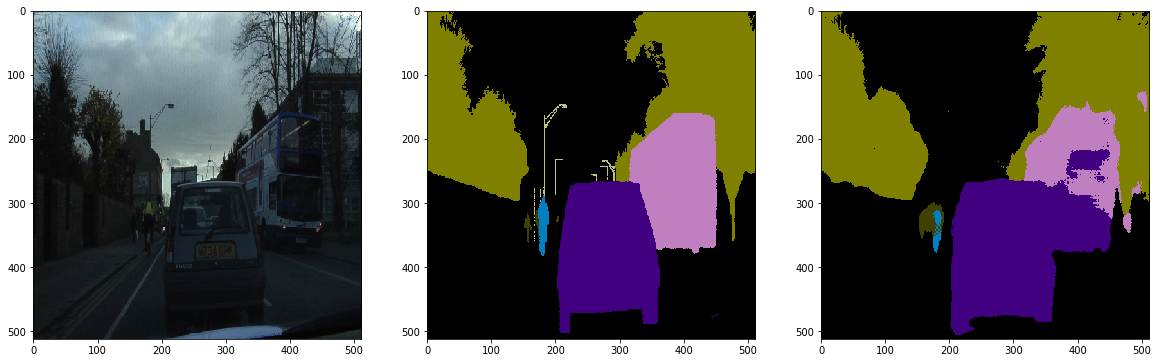

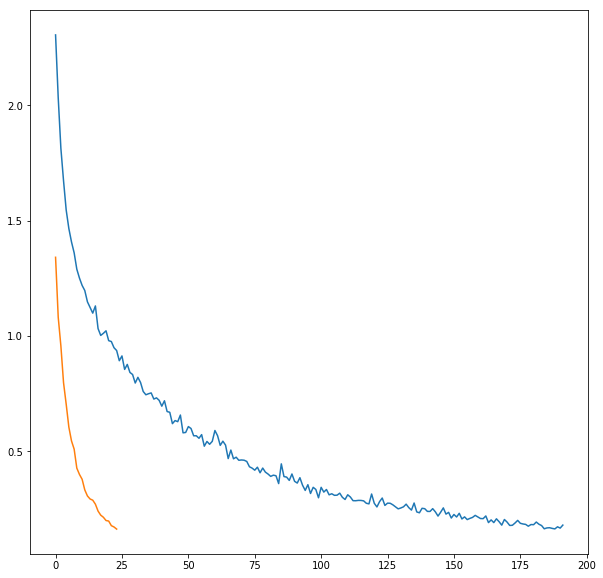

Epoch : 24
Training .....
Epoch 1/1
80/80 [==============================] - 10s 128ms/step - loss: 0.1706 - jaccard_distance: 0.1956
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.1594 - jaccard_distance: 0.1912
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.1669 - jaccard_distance: 0.1933
Epoch 1/1
80/80 [==============================] - 10s 128ms/step - loss: 0.1790 - jaccard_distance: 0.2024
Epoch 1/1
80/80 [==============================] - 10s 128ms/step - loss: 0.1755 - jaccard_distance: 0.2033
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.1770 - jaccard_distance: 0.2049
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.1560 - jaccard_distance: 0.1894
Epoch 1/1
69/69 [==============================] - 9s 129ms/step - loss: 0.1604 - jaccard_distance: 0.1847
Validating .....
Epoch 1/1
16/16 [==============================] - 2s 131ms/step - loss: 0.1425 - jaccard_dist

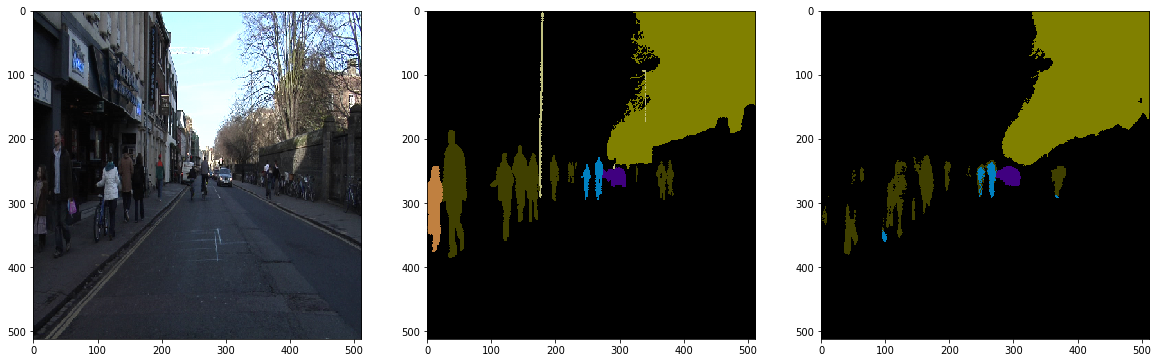

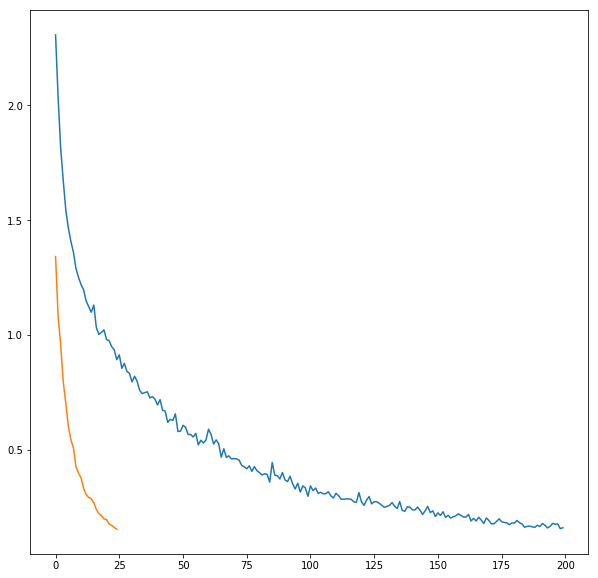

Epoch : 25
Training .....
Epoch 1/1
80/80 [==============================] - 10s 128ms/step - loss: 0.1533 - jaccard_distance: 0.1828
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.1524 - jaccard_distance: 0.1785
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.1586 - jaccard_distance: 0.1851
Epoch 1/1
80/80 [==============================] - 10s 128ms/step - loss: 0.1508 - jaccard_distance: 0.1814
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.1520 - jaccard_distance: 0.1765
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.1441 - jaccard_distance: 0.1732
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.1527 - jaccard_distance: 0.1788
Epoch 1/1
69/69 [==============================] - 9s 129ms/step - loss: 0.1637 - jaccard_distance: 0.1883
Validating .....
Epoch 1/1
16/16 [==============================] - 2s 130ms/step - loss: 0.1415 - jaccard_dist

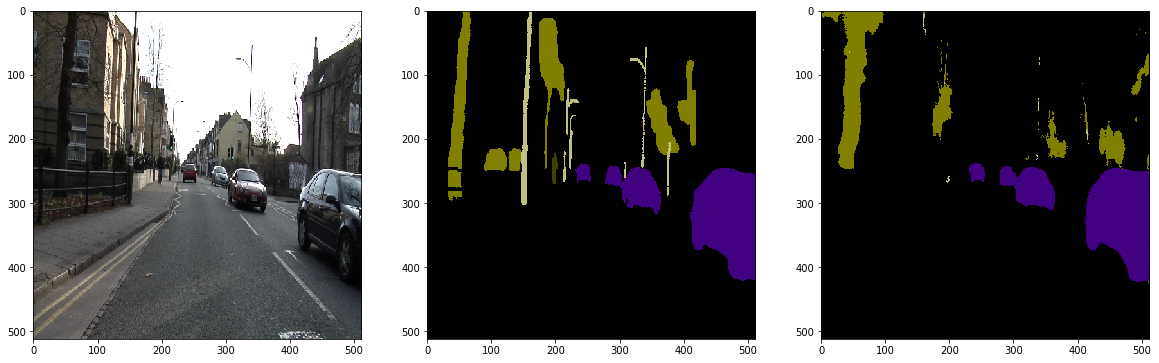

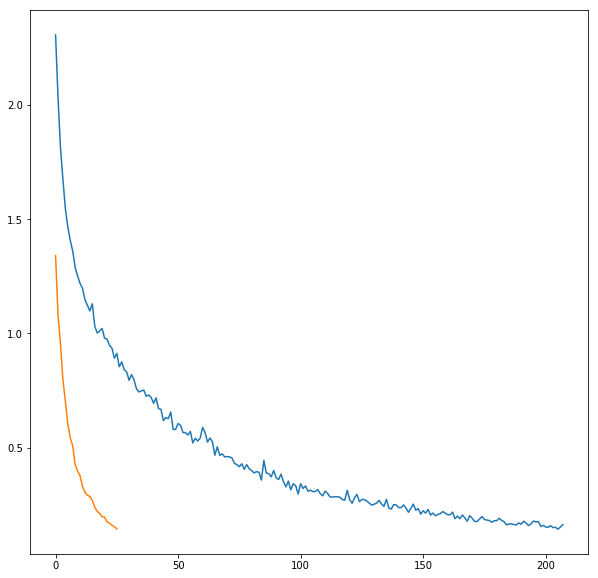

Epoch : 26
Training .....
Epoch 1/1
80/80 [==============================] - 10s 128ms/step - loss: 0.1669 - jaccard_distance: 0.1890
Epoch 1/1
80/80 [==============================] - 10s 128ms/step - loss: 0.1457 - jaccard_distance: 0.1738
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.1319 - jaccard_distance: 0.1622
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.1375 - jaccard_distance: 0.1650
Epoch 1/1
80/80 [==============================] - 10s 130ms/step - loss: 0.1606 - jaccard_distance: 0.1744
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.1647 - jaccard_distance: 0.1900
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.1595 - jaccard_distance: 0.1851
Epoch 1/1
69/69 [==============================] - 9s 129ms/step - loss: 0.1530 - jaccard_distance: 0.1803
Validating .....
Epoch 1/1
16/16 [==============================] - 2s 130ms/step - loss: 0.2079 - jaccard_dist

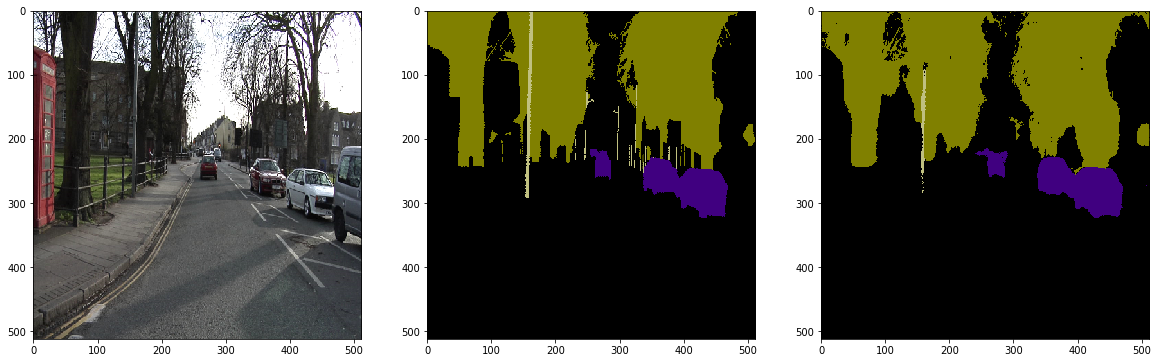

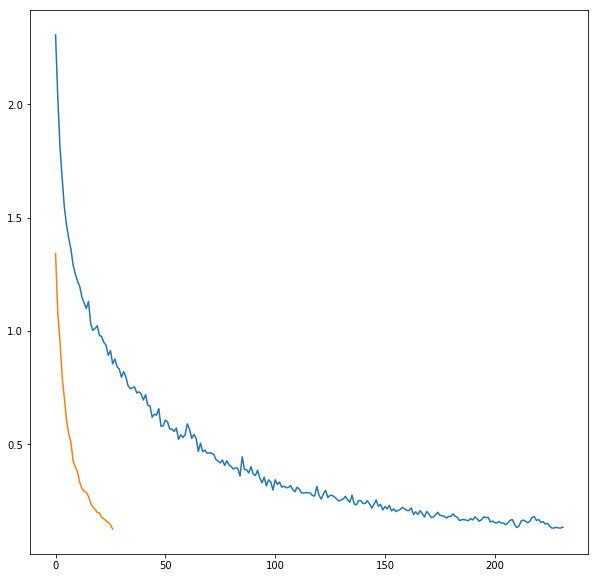

Epoch : 29
Training .....
Epoch 1/1
80/80 [==============================] - 10s 128ms/step - loss: 0.1379 - jaccard_distance: 0.1607
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.1230 - jaccard_distance: 0.1462
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.1357 - jaccard_distance: 0.1586
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.1215 - jaccard_distance: 0.1417
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.1121 - jaccard_distance: 0.1375
Epoch 1/1
80/80 [==============================] - 10s 130ms/step - loss: 0.1277 - jaccard_distance: 0.1511
Epoch 1/1
80/80 [==============================] - 10s 129ms/step - loss: 0.1232 - jaccard_distance: 0.1428
Epoch 1/1
69/69 [==============================] - 9s 129ms/step - loss: 0.1176 - jaccard_distance: 0.1411
Validating .....
Epoch 1/1
16/16 [==============================] - 2s 131ms/step - loss: 0.1269 - jaccard_dist

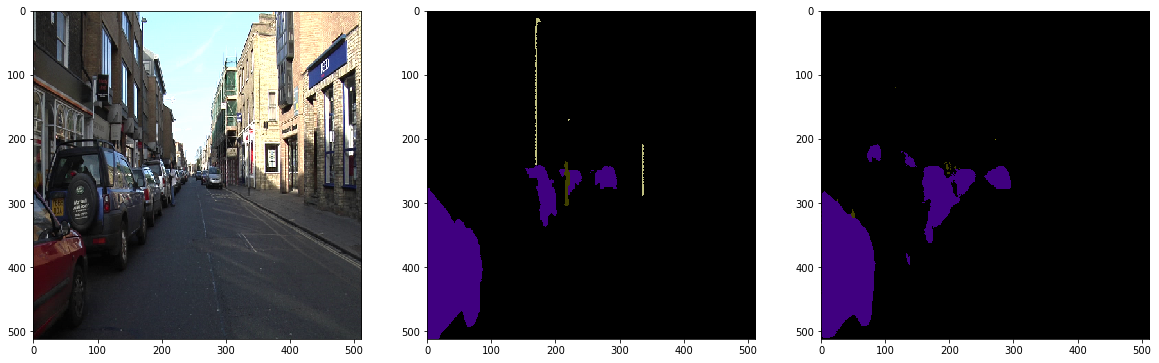

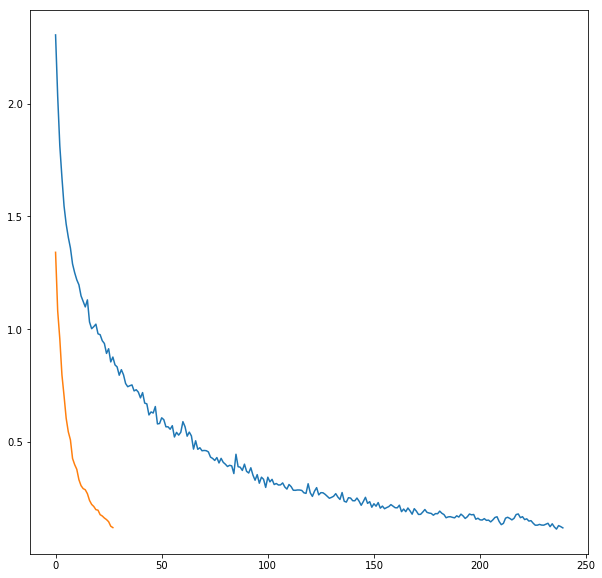

In [25]:
epochs = 30
batch_size = 8
lr = 1e-4
unet.train(epochs=epochs , lr = 1e-4 , dataset = proc , batch_size = batch_size , 
           validation = True , pretrained = False , class_weights = class_weights , model_name = "model2.h5")

# Observation of  Frame to Segmentation Map


*   Always us Xavier initialisation with U-net , convergence rate is higher 
*   Batchnormalisation allows the the use of high learning rate
*  This maybe important for camvid only , but weighting might be important , its more a dataset feature than the mdoels
*  Remember Sparsity is already introduced by Conv layers no purpose of adding dropout there unless there are way to many number of filters
